In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
import tensorflow

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Flatten, Input, Conv2D, LSTM, GRU, BatchNormalization, MaxPooling2D, Reshape
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
from numpy.random import seed
seed(13)
tensorflow.random.set_seed(2)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive


drive.mount('/content/gdrive')
current_path = os.path.join(os.getcwd(), 'gdrive/MyDrive')
dataset_path = os.path.join(current_path,"speech_commands_v0_02_dataset")
path_save_downsampled = os.path.join(current_path, "speech_commands_data/downsampled_dataset")
path_save_small = os.path.join(current_path, "speech_commands_data/small_dataset")


path_save_small_logmelspectrogram = os.path.join(path_save_small, 'log_mel_spectrogram')


Mounted at /content/gdrive


In [ ]:
os.listdir(path_save_small_logmelspectrogram)

['Mal',
 'x_train_small_logmelspectrogram.pickle',
 'x_val_small_logmelspectrogram.pickle',
 'x_test_small_logmelspectrogram.pickle',
 'x_train_small_logmelspectrogram.np.npy',
 'x_val_small_logmelspectrogram.np.npy',
 'x_test_small_logmelspectrogram.np.npy',
 'x_train_small_logmelspectrogram_1.npy',
 'x_val_small_logmelspectrogram_1.npy',
 'x_test_small_logmelspectrogram_1.npy']

In [ ]:
def load_object(path_to_file):
  with open(path_to_file, "rb") as input_file:
    object = pickle.load(input_file)
  return object

def save_with_pickle(name_file, data, path_to_safe):
  with open(os.path.join(path_to_safe, name_file), "wb") as file:
      pickle.dump(data, file)

# Creation of classes

In [ ]:

small_train_label = load_object(os.path.join(path_save_small, 'cleaned_label_train_small.pickle'))
small_val_label = load_object(os.path.join(path_save_small, 'cleaned_label_val_small.pickle'))
small_test_label = load_object(os.path.join(path_save_small, 'cleaned_label_test_small.pickle'))

In [ ]:
commands_unkown_word = {"bed", "bird", "cat", "dog", "happy", "house", "marvin", "sheila", "tree", "wow"}
commands = np.unique(small_train_label)

In [ ]:

def assign_num_to_command(commands, commands_unkown_word):
  """Assigns a number to each command. Commands belonging to commands_unkown_word
  will be assigned the same number (the last one).

  :param commands: List of all commands, including the ones that belong to
  command_unkown_word.
  :param commands_unkown_word: List of commands that belong to unknown word class.
  :return: Dictionary that maps each class with a number.
  """
  commands_numerical = {}

  c = 0
  for command in commands:
    if command not in commands_unkown_word:
      commands_numerical[str(command)] = c
      c += 1
    else:
      commands_numerical[str(command)] = len(commands) - len(commands_unkown_word)
  return(commands_numerical)

def create_label_numerical_array(labels):
  """Returns an array that has replaced the classes in "labels" by their
  assigned numbers.
  :param labels: List of labels (classes) of instances.
  :return: Array with the labels replaced by the corresponding number.
  """
  commands_numerical = assign_num_to_command(commands, commands_unkown_word)

  y_array = np.array(labels, dtype=object)
  for command in commands:
    y_array = np.where(y_array == command, commands_numerical[str(command)], y_array)
  return y_array


In [ ]:
label_train = create_label_numerical_array(small_train_label)

n_classes = len(set(label_train))

# One-hot encoding
y_train = to_categorical(label_train, num_classes=n_classes)
y_val = to_categorical(create_label_numerical_array(small_val_label), num_classes=n_classes)
y_test = to_categorical(create_label_numerical_array(small_test_label), num_classes=n_classes)


In [ ]:
classes = set(commands) - set(commands_unkown_word)
classes = np.unique(list(classes))
classes = np.append(classes, 'unkown_word')

# Load data

In [ ]:
small_train_data = np.load(os.path.join(path_save_small_logmelspectrogram , 'x_train_small_logmelspectrogram_1.npy'))
small_val_data = np.load(os.path.join(path_save_small_logmelspectrogram , 'x_val_small_logmelspectrogram_1.npy'))
small_test_data = np.load(os.path.join(path_save_small_logmelspectrogram , 'x_test_small_logmelspectrogram_1.npy'))


In [ ]:
small_train_data.shape

(13050, 63, 128)

In [ ]:
# Normalize data
train_shape = np.array(small_train_data).shape

x_train_flattened = small_train_data.flatten()

scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train_flattened.reshape(-1, 1))

x_train = x_train_normalized.reshape(train_shape)

def normalize_data(data, scaler):
  shape = data.shape
  data_flattened = data.flatten()
  data_normalized = scaler.transform(data_flattened.reshape(-1,1))
  return data_normalized.reshape(shape)


In [ ]:
x_train.shape

(13050, 63, 128)

In [ ]:
x_val = normalize_data(small_val_data, scaler)
x_test = normalize_data(small_test_data, scaler)

In [ ]:

input_shape = (63, 128, 1)

In [ ]:
input_shape

(63, 128, 1)

# Functions for evaluating model

In [ ]:
class MetricsInfoShower:
  """Class for showing reports and graphics regarding training and test
  evaluation."""

  def __init__(self, model, h_model, x, y_true, batch_size, classes) -> None:
    self.model = model
    self.h_model = h_model
    self.last_epoch = len(self.h_model.history['loss'])
    self.batch_size = batch_size
    self.y_true = np.argmax(y_test, axis=1)
    self.y_pred = self._get_y_pred(x)
    self.classes = classes



  def _get_y_pred(self, x):
    y_pred = self.model.predict(x, batch_size=self.batch_size)
    return y_pred.argmax(axis=1)

  def show_classification_report(self):
    # Evaluación del modelo
    print("[INFO]: Evaluando el modelo...")

    # Report
    print(classification_report(self.y_true, self.y_pred, target_names=self.classes))

  def show_confusion_matrix(self):
    # Calcula la matriz de confusión
    cm = confusion_matrix(self.y_true, self.y_pred, normalize='pred')

    # Crea un gráfico de matriz de confusión utilizando seaborn
    plt.figure(figsize = (16, 16))
    ax = sns.heatmap(cm, annot=True, cmap="PuBu", fmt=".2f", xticklabels=self.classes, yticklabels=classes, vmin = 0.1 )

    # Añade etiquetas y título
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Real")
    plt.title("Matriz de Confusión")

    plt.show()

  def show_training_loss(self):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["loss"], label="train_loss")
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

  def show_training_accuracy(self):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

  def show_all(self):
    self.show_training_loss()
    self.show_training_accuracy()
    self.show_classification_report()
    self.show_confusion_matrix()

### Experimento_A_cnn_lme_1_00

In [ ]:
exp_a_cnn_lme_1_00 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_1_00.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x, verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_1_00.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_1_00.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 64
h_exp_a_cnn_lme_1_00 = exp_a_cnn_lme_1_00.fit(x_train, y_train,
                                              batch_size=batch_size, epochs=50,
                                              validation_data=(x_val, y_val),
                                              callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1723 - loss: 2.8749
Epoch 1: val_loss improved from inf to 1.81844, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.1729 - loss: 2.8727 - val_accuracy: 0.4785 - val_loss: 1.8184 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/50
201/204 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5207 - loss: 1.6316
Epoch 2: val_loss improved from 1.81844 to 1.51027, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5213 - loss: 1.6295 - val_accuracy: 0.5555 - val_loss: 1.5103 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/50
196/204 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6312 - loss: 1.2322
Epoch 3: val_loss improved from 1.51027 to 1.37760, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6322 - loss: 1.2296 - val_accuracy: 0.5781 - val_loss: 1.3776 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/50
201/204 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6938 - loss: 1.0077
Epoch 4: val_loss improved from 1.37760 to 1.34894, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6941 - loss: 1.0068 - val_accuracy: 0.6083 - val_loss: 1.3489 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/50
198/204 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7440 - loss: 0.8470
Epoch 5: val_loss improved from 1.34894 to 1.31980, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7443 - loss: 0.8459 - val_accuracy: 0.6309 - val_loss: 1.3198 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7766 - loss: 0.7312
Epoch 6: val_loss did not improve from 1.31980
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7767 - loss: 0.7310 - val_accuracy: 0.6302 - val_loss: 1.3233 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/50
201/204 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8016 - loss: 0.6349
Epoch 7: val_loss improved from 1.31980 to 1.28841, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8019 - loss: 0.6342 - val_accuracy: 0.6453 - val_loss: 1.2884 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/50
202/204 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8320 - loss: 0.5433
Epoch 8: val_loss did not improve from 1.28841
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8322 - loss: 0.5430 - val_accuracy: 0.6483 - val_loss: 1.3159 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/50
203/204 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8596 - loss: 0.4626
Epoch 9: val_loss did not improve from 1.28841
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8596 - loss: 0.4624 - val_accuracy: 0.6468 - val_loss: 1.4033 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc

In [ ]:
exp_a_cnn_lme_1_00.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 61, 126, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 61, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 26880)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,440,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,557,584 (40.27 MB)

 Trainable params: 3,519,194 (13.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,038,390 (26.85 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


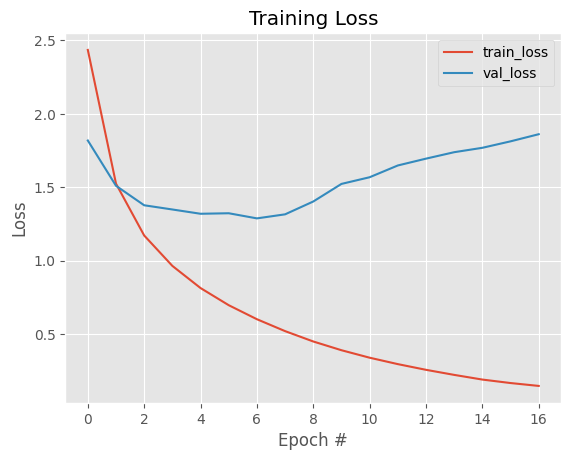

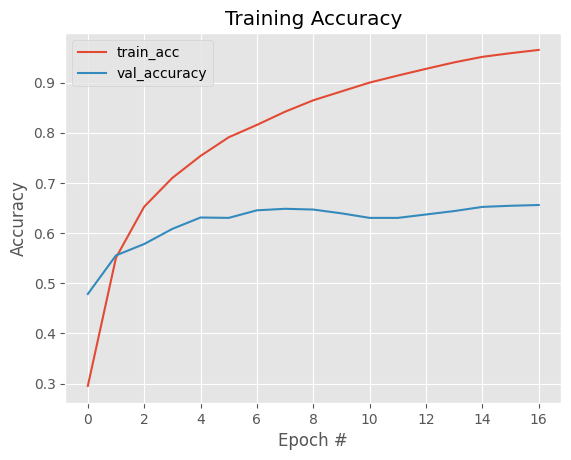

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.77      0.74      0.75        62
        down       0.55      0.53      0.54        62
       eight       0.84      0.74      0.79        62
        five       0.61      0.55      0.58        62
      follow       0.54      0.60      0.57        62
     forward       0.64      0.69      0.67        62
        four       0.67      0.53      0.59        62
          go       0.49      0.58      0.53        62
       learn       0.54      0.60      0.57        62
        left       0.68      0.66      0.67        62
        nine       0.69      0.76      0.72        62
          no       0.55      0.45      0.50        62
         off       0.60      0.55      0.57        62
          on       0.64      0.45      0.53        62
         one       0.70      0.56      0.62        62
       right       0.84      0.68      0.75        62
       seven       0.82      0.65      0.72       

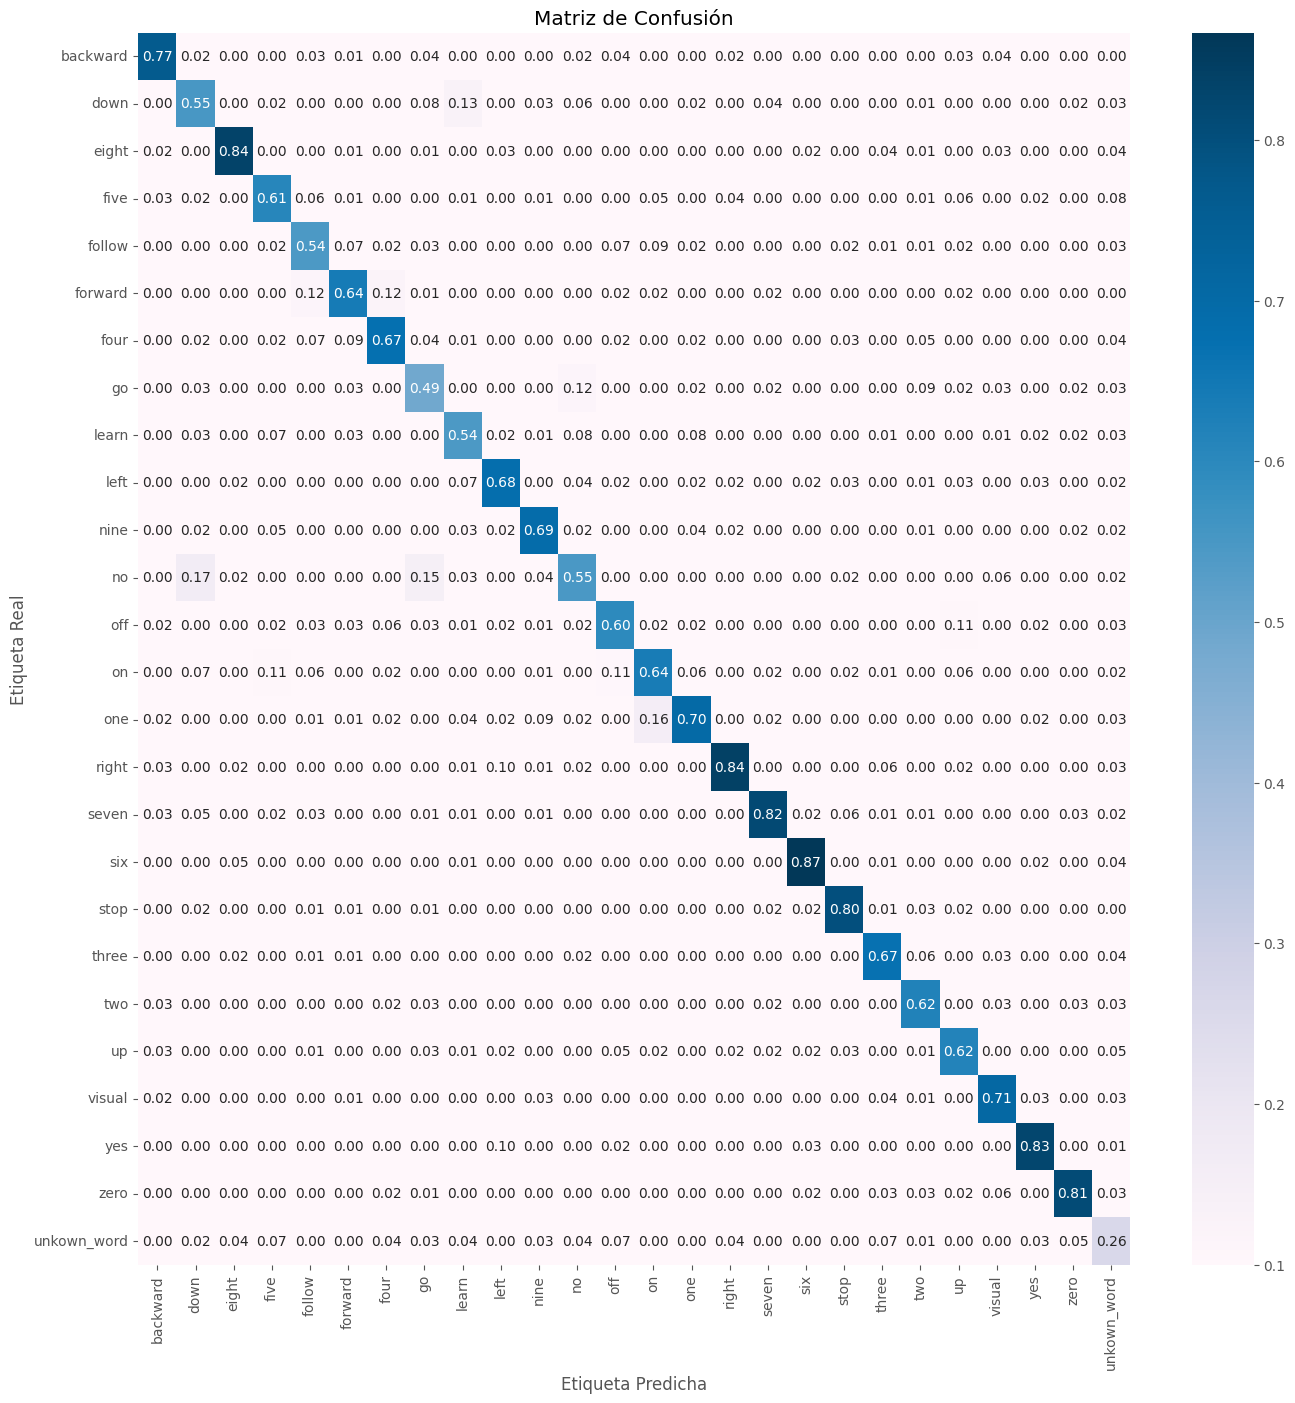

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_1_00, h_exp_a_cnn_lme_1_00, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_1_01

In [ ]:
exp_a_cnn_lme_1_01 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_1_01.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_1_01.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_1_01.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_1_01 = exp_a_cnn_lme_1_01.fit(x_train, y_train,
                                              batch_size=batch_size, epochs=90,
                                              validation_data=(x_val, y_val),
                                              callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0867 - loss: 3.6774
Epoch 1: val_loss improved from inf to 4.73203, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.0867 - loss: 3.6764 - val_accuracy: 0.1208 - val_loss: 4.7320 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1832 - loss: 2.8263
Epoch 2: val_loss improved from 4.73203 to 2.64624, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1833 - loss: 2.8259 - val_accuracy: 0.2249 - val_loss: 2.6462 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2925 - loss: 2.3885
Epoch 3: val_loss improved from 2.64624 to 2.33862, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2926 - loss: 2.3882 - val_accuracy: 0.3072 - val_loss: 2.3386 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4154 - loss: 1.9411
Epoch 4: val_loss improved from 2.33862 to 1.88370, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4155 - loss: 1.9403 - val_accuracy: 0.4151 - val_loss: 1.8837 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5215 - loss: 1.5135
Epoch 5: val_loss improved from 1.88370 to 1.77363, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5215 - loss: 1.5133 - val_accuracy: 0.4755 - val_loss: 1.7736 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6247 - loss: 1.1609
Epoch 6: val_loss improved from 1.77363 to 1.63394, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6248 - loss: 1.1607 - val_accuracy: 0.5283 - val_loss: 1.6339 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7132 - loss: 0.8679
Epoch 7: val_loss did not improve from 1.63394
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7132 - loss: 0.8678 - val_accuracy: 0.5291 - val_loss: 1.7493 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7945 - loss: 0.6337
Epoch 8: val_loss improved from 1.63394 to 1.56297, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7945 - loss: 0.6336 - val_accuracy: 0.5849 - val_loss: 1.5630 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8437 - loss: 0.4780
Epoch 9: val_loss did not improve from 1.56297
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8439 - loss: 0.4774 - val_accuracy: 0.5902 - val_loss: 1.6874 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8875 - loss: 0.3596
Epoch 10: val_loss did not improve from 1.56297
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8877 - loss: 0.3593 - val_accuracy: 0.5940 - val_loss: 1.6772 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

In [ ]:
exp_a_cnn_lme_1_01.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 61, 126, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 61, 126, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 61, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 26880)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,440,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,559,120 (40.28 MB)

 Trainable params: 3,519,578 (13.43 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 7,039,158 (26.85 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


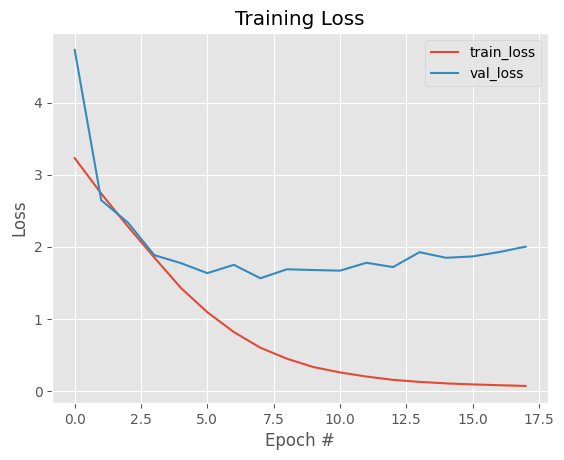

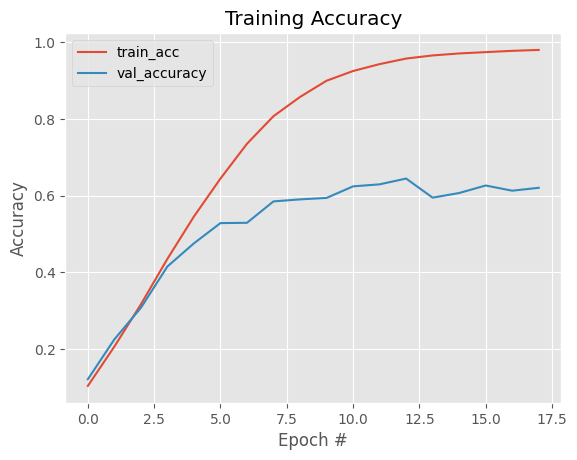

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.85      0.65      0.73        62
        down       0.68      0.65      0.66        62
       eight       0.71      0.73      0.72        62
        five       0.54      0.60      0.57        62
      follow       0.49      0.63      0.55        62
     forward       0.60      0.48      0.54        62
        four       0.46      0.42      0.44        62
          go       0.54      0.66      0.59        62
       learn       0.45      0.55      0.50        62
        left       0.77      0.71      0.74        62
        nine       0.69      0.73      0.71        62
          no       0.62      0.68      0.65        62
         off       0.90      0.58      0.71        62
          on       0.84      0.50      0.63        62
         one       0.64      0.61      0.63        62
       right       0.88      0.69      0.77        62
       seven       0.75      0.68      0.71       

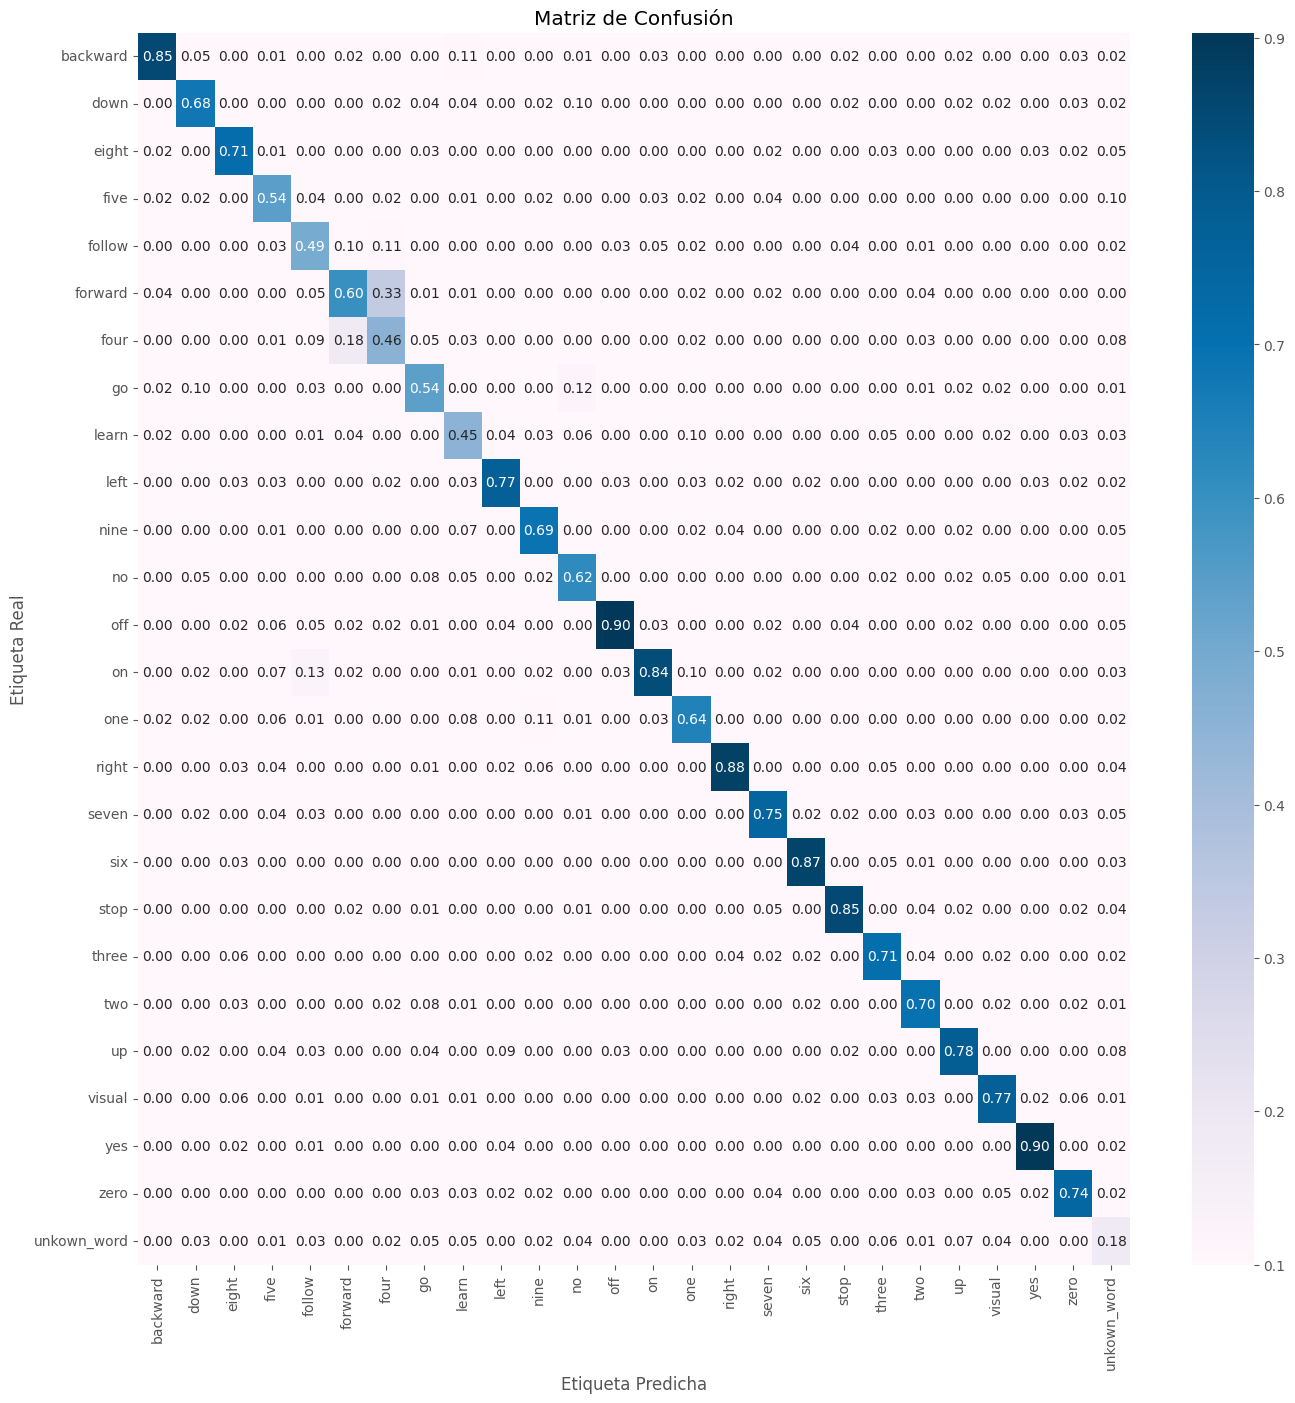

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_1_01, h_exp_a_cnn_lme_1_01, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_1_02

In [ ]:
exp_a_cnn_lme_1_02 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    # Capa de salida
    Dense(n_classes, activation='softmax')])

exp_a_cnn_lme_1_02.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_1_02.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_1_02.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_1_02 = exp_a_cnn_lme_1_02.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0446 - loss: 3.9546
Epoch 1: val_loss improved from inf to 3.85499, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.0446 - loss: 3.9533 - val_accuracy: 0.0408 - val_loss: 3.8550 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0617 - loss: 3.2018
Epoch 2: val_loss improved from 3.85499 to 3.16643, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0618 - loss: 3.2015 - val_accuracy: 0.0672 - val_loss: 3.1664 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0732 - loss: 3.1258
Epoch 3: val_loss improved from 3.16643 to 3.02914, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0733 - loss: 3.1255 - val_accuracy: 0.1125 - val_loss: 3.0291 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0949 - loss: 3.0572
Epoch 4: val_loss improved from 3.02914 to 2.87719, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0950 - loss: 3.0568 - val_accuracy: 0.1442 - val_loss: 2.8772 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1176 - loss: 2.9458
Epoch 5: val_loss improved from 2.87719 to 2.79456, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1177 - loss: 2.9457 - val_accuracy: 0.1691 - val_loss: 2.7946 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1404 - loss: 2.8663
Epoch 6: val_loss improved from 2.79456 to 2.73398, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1405 - loss: 2.8659 - val_accuracy: 0.1645 - val_loss: 2.7340 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1562 - loss: 2.7669
Epoch 7: val_loss improved from 2.73398 to 2.58633, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1563 - loss: 2.7667 - val_accuracy: 0.2000 - val_loss: 2.5863 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1764 - loss: 2.6845
Epoch 8: val_loss improved from 2.58633 to 2.51140, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1766 - loss: 2.6839 - val_accuracy: 0.2468 - val_loss: 2.5114 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2075 - loss: 2.5751
Epoch 9: val_loss improved from 2.51140 to 2.41523, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2077 - loss: 2.5747 - val_accuracy: 0.2815 - val_loss: 2.4152 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2416 - loss: 2.4659
Epoch 10: val_loss improved from 2.41523 to 2.32344, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2416 - loss: 2.4658 - val_accuracy: 0.2966 - val_loss: 2.3234 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2663 - loss: 2.3916
Epoch 11: val_loss improved from 2.32344 to 2.25593, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2662 - loss: 2.3915 - val_accuracy: 0.3094 - val_loss: 2.2559 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2755 - loss: 2.3248
Epoch 12: val_loss improved from 2.25593 to 2.20996, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2755 - loss: 2.3248 - val_accuracy: 0.3374 - val_loss: 2.2100 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2937 - loss: 2.2622
Epoch 13: val_loss improved from 2.20996 to 2.18247, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2936 - loss: 2.2623 - val_accuracy: 0.3494 - val_loss: 2.1825 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3069 - loss: 2.2083
Epoch 14: val_loss improved from 2.18247 to 2.13021, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3069 - loss: 2.2082 - val_accuracy: 0.3721 - val_loss: 2.1302 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3205 - loss: 2.1569
Epoch 15: val_loss improved from 2.13021 to 2.08900, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3204 - loss: 2.1569 - val_accuracy: 0.3706 - val_loss: 2.0890 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3365 - loss: 2.1067
Epoch 16: val_loss improved from 2.08900 to 2.07018, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3365 - loss: 2.1065 - val_accuracy: 0.3789 - val_loss: 2.0702 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3475 - loss: 2.0641
Epoch 17: val_loss improved from 2.07018 to 2.04297, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3475 - loss: 2.0640 - val_accuracy: 0.3743 - val_loss: 2.0430 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3533 - loss: 2.0299
Epoch 18: val_loss improved from 2.04297 to 1.98822, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3533 - loss: 2.0299 - val_accuracy: 0.3992 - val_loss: 1.9882 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3682 - loss: 2.0018
Epoch 19: val_loss did not improve from 1.98822
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3682 - loss: 2.0017 - val_accuracy: 0.4053 - val_loss: 1.9892 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3841 - loss: 1.9471
Epoch 20: val_loss improved from 1.98822 to 1.97136, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3841 - loss: 1.9471 - val_accuracy: 0.4287 - val_loss: 1.9714 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3902 - loss: 1.9040
Epoch 21: val_loss improved from 1.97136 to 1.93183, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3902 - loss: 1.9040 - val_accuracy: 0.4257 - val_loss: 1.9318 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3961 - loss: 1.8801
Epoch 22: val_loss improved from 1.93183 to 1.91459, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3961 - loss: 1.8800 - val_accuracy: 0.4264 - val_loss: 1.9146 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4137 - loss: 1.8461
Epoch 23: val_loss improved from 1.91459 to 1.89216, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4136 - loss: 1.8462 - val_accuracy: 0.4332 - val_loss: 1.8922 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4133 - loss: 1.8316
Epoch 24: val_loss did not improve from 1.89216
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4133 - loss: 1.8315 - val_accuracy: 0.4272 - val_loss: 1.9110 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4159 - loss: 1.8087
Epoch 25: val_loss improved from 1.89216 to 1.87694, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4161 - loss: 1.8085 - val_accuracy: 0.4415 - val_loss: 1.8769 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4204 - loss: 1.7911
Epoch 26: val_loss improved from 1.87694 to 1.86045, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4205 - loss: 1.7909 - val_accuracy: 0.4460 - val_loss: 1.8605 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4328 - loss: 1.7734
Epoch 27: val_loss improved from 1.86045 to 1.86011, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4327 - loss: 1.7733 - val_accuracy: 0.4408 - val_loss: 1.8601 - learning_rate: 6.4611e-05

Epoch 28: LearningRateScheduler setting learning rate to 5.8149737003040094e-05.
Epoch 28/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4401 - loss: 1.7498
Epoch 28: val_loss improved from 1.86011 to 1.85545, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4402 - loss: 1.7497 - val_accuracy: 0.4423 - val_loss: 1.8555 - learning_rate: 5.8150e-05

Epoch 29: LearningRateScheduler setting learning rate to 5.233476330273609e-05.
Epoch 29/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4468 - loss: 1.7461
Epoch 29: val_loss did not improve from 1.85545
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4468 - loss: 1.7459 - val_accuracy: 0.4415 - val_loss: 1.8572 - learning_rate: 5.2335e-05

Epoch 30: LearningRateScheduler setting learning rate to 4.7101286972462485e-05.
Epoch 30/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4365 - loss: 1.7228
Epoch 30: val_loss improved from 1.85545 to 1.83767, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4366 - loss: 1.7227 - val_accuracy: 0.4491 - val_loss: 1.8377 - learning_rate: 4.7101e-05

Epoch 31: LearningRateScheduler setting learning rate to 4.239115827521624e-05.
Epoch 31/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4516 - loss: 1.7039
Epoch 31: val_loss improved from 1.83767 to 1.82955, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4516 - loss: 1.7041 - val_accuracy: 0.4483 - val_loss: 1.8296 - learning_rate: 4.2391e-05

Epoch 32: LearningRateScheduler setting learning rate to 3.8152042447694614e-05.
Epoch 32/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4467 - loss: 1.7017
Epoch 32: val_loss improved from 1.82955 to 1.82732, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4467 - loss: 1.7016 - val_accuracy: 0.4551 - val_loss: 1.8273 - learning_rate: 3.8152e-05

Epoch 33: LearningRateScheduler setting learning rate to 3.433683820292515e-05.
Epoch 33/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4583 - loss: 1.6829
Epoch 33: val_loss improved from 1.82732 to 1.82092, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4583 - loss: 1.6829 - val_accuracy: 0.4506 - val_loss: 1.8209 - learning_rate: 3.4337e-05

Epoch 34: LearningRateScheduler setting learning rate to 3.090315438263264e-05.
Epoch 34/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4615 - loss: 1.6704
Epoch 34: val_loss improved from 1.82092 to 1.81138, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4614 - loss: 1.6704 - val_accuracy: 0.4596 - val_loss: 1.8114 - learning_rate: 3.0903e-05

Epoch 35: LearningRateScheduler setting learning rate to 2.7812838944369376e-05.
Epoch 35/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4601 - loss: 1.6558
Epoch 35: val_loss did not improve from 1.81138
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4601 - loss: 1.6561 - val_accuracy: 0.4551 - val_loss: 1.8169 - learning_rate: 2.7813e-05

Epoch 36: LearningRateScheduler setting learning rate to 2.5031555049932436e-05.
Epoch 36/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4599 - loss: 1.6691
Epoch 36: val_loss improved from 1.81138 to 1.81126, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4599 - loss: 1.6692 - val_accuracy: 0.4536 - val_loss: 1.8113 - learning_rate: 2.5032e-05

Epoch 37: LearningRateScheduler setting learning rate to 2.2528399544939195e-05.
Epoch 37/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4673 - loss: 1.6472
Epoch 37: val_loss did not improve from 1.81126
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4673 - loss: 1.6472 - val_accuracy: 0.4604 - val_loss: 1.8193 - learning_rate: 2.2528e-05

Epoch 38: LearningRateScheduler setting learning rate to 2.0275559590445276e-05.
Epoch 38/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4654 - loss: 1.6586
Epoch 38: val_loss improved from 1.81126 to 1.80876, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4653 - loss: 1.6585 - val_accuracy: 0.4536 - val_loss: 1.8088 - learning_rate: 2.0276e-05

Epoch 39: LearningRateScheduler setting learning rate to 1.824800363140075e-05.
Epoch 39/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4765 - loss: 1.6332
Epoch 39: val_loss did not improve from 1.80876
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4764 - loss: 1.6333 - val_accuracy: 0.4611 - val_loss: 1.8120 - learning_rate: 1.8248e-05

Epoch 40: LearningRateScheduler setting learning rate to 1.6423203268260675e-05.
Epoch 40/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4699 - loss: 1.6442
Epoch 40: val_loss did not improve from 1.80876
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4699 - loss: 1.6444 - val_accuracy: 0.4642 - val_loss: 1.8132 - learning_rate: 1.6423e-05

Epoch 41: LearningRateScheduler setting learning rate to 1.4780882941434608e-05.
Epoch 41/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4777 - loss: 1.6202 - val_accuracy: 0.4566 - val_loss: 1.8061 - learning_rate: 1.4781e-05

Epoch 42: LearningRateScheduler setting learning rate to 1.3302794647291146e-05.
Epoch 42/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4782 - loss: 1.6232
Epoch 42: val_loss improved from 1.80607 to 1.80419, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4781 - loss: 1.6234 - val_accuracy: 0.4566 - val_loss: 1.8042 - learning_rate: 1.3303e-05

Epoch 43: LearningRateScheduler setting learning rate to 1.1972515182562033e-05.
Epoch 43/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4780 - loss: 1.6428
Epoch 43: val_loss did not improve from 1.80419
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4780 - loss: 1.6428 - val_accuracy: 0.4551 - val_loss: 1.8082 - learning_rate: 1.1973e-05

Epoch 44: LearningRateScheduler setting learning rate to 1.077526366430583e-05.
Epoch 44/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4755 - loss: 1.6086
Epoch 44: val_loss did not improve from 1.80419
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4754 - loss: 1.6087 - val_accuracy: 0.4551 - val_loss: 1.8069 - learning_rate: 1.0775e-05

Epoch 45: LearningRateScheduler setting learning rate to 9.697737297875246e-06.
Epoch 45/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4834 - loss: 1.6065 - val_accuracy: 0.4611 - val_loss: 1.8039 - learning_rate: 4.6384e-06

Epoch 53: LearningRateScheduler setting learning rate to 4.174557917929297e-06.
Epoch 53/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4858 - loss: 1.6062
Epoch 53: val_loss did not improve from 1.80387
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4858 - loss: 1.6060 - val_accuracy: 0.4581 - val_loss: 1.8058 - learning_rate: 4.1746e-06

Epoch 54: LearningRateScheduler setting learning rate to 3.7571021261363675e-06.
Epoch 54/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4853 - loss: 1.5906
Epoch 54: val_loss improved from 1.80387 to 1.80365, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4852 - loss: 1.5907 - val_accuracy: 0.4619 - val_loss: 1.8037 - learning_rate: 3.7571e-06

Epoch 55: LearningRateScheduler setting learning rate to 3.381391913522731e-06.
Epoch 55/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4757 - loss: 1.6134
Epoch 55: val_loss did not improve from 1.80365
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4757 - loss: 1.6134 - val_accuracy: 0.4581 - val_loss: 1.8070 - learning_rate: 3.3814e-06

Epoch 56: LearningRateScheduler setting learning rate to 3.0432527221704577e-06.
Epoch 56/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4865 - loss: 1.5942
Epoch 56: val_loss did not improve from 1.80365
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4863 - loss: 1.5945 - val_accuracy: 0.4604 - val_loss: 1.8062 - learning_rate: 3.0433e-06

Epoch 57: LearningRateScheduler setting learning rate to 2.7389274499534123e-06.
Epoch 57/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4910 - loss: 1.5919 - val_accuracy: 0.4596 - val_loss: 1.8032 - learning_rate: 2.2185e-06

Epoch 60: LearningRateScheduler setting learning rate to 1.9966781110160375e-06.
Epoch 60/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4836 - loss: 1.5865
Epoch 60: val_loss did not improve from 1.80316
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4835 - loss: 1.5865 - val_accuracy: 0.4619 - val_loss: 1.8077 - learning_rate: 1.9967e-06

Epoch 61: LearningRateScheduler setting learning rate to 1.797010299914434e-06.
Epoch 61/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4808 - loss: 1.6013
Epoch 61: val_loss did not improve from 1.80316
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4809 - loss: 1.6012 - val_accuracy: 0.4581 - val_loss: 1.8035 - learning_rate: 1.7970e-06

Epoch 62: LearningRateScheduler setting learning rate to 1.6173092699229906e-06.
Epoch 62/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4921 - loss: 1.5811 - val_accuracy: 0.4634 - val_loss: 1.8031 - learning_rate: 1.3100e-06

Epoch 65: LearningRateScheduler setting learning rate to 1.1790184577738603e-06.
Epoch 65/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4896 - loss: 1.5828
Epoch 65: val_loss did not improve from 1.80310
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4895 - loss: 1.5829 - val_accuracy: 0.4626 - val_loss: 1.8039 - learning_rate: 1.1790e-06

Epoch 66: LearningRateScheduler setting learning rate to 1.061116611996474e-06.
Epoch 66/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4892 - loss: 1.5800
Epoch 66: val_loss did not improve from 1.80310
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4891 - loss: 1.5802 - val_accuracy: 0.4596 - val_loss: 1.8035 - learning_rate: 1.0611e-06

Epoch 67: LearningRateScheduler setting learning rate to 9.550049507968267e-07.
Epoch 67/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4929 - loss: 1.5872 - val_accuracy: 0.4604 - val_loss: 1.8023 - learning_rate: 9.5500e-07

Epoch 68: LearningRateScheduler setting learning rate to 8.595044557171441e-07.
Epoch 68/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4927 - loss: 1.5997
Epoch 68: val_loss improved from 1.80230 to 1.80201, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4926 - loss: 1.5998 - val_accuracy: 0.4596 - val_loss: 1.8020 - learning_rate: 8.5950e-07

Epoch 69: LearningRateScheduler setting learning rate to 7.735540101454298e-07.
Epoch 69/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4902 - loss: 1.5845
Epoch 69: val_loss did not improve from 1.80201
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4902 - loss: 1.5845 - val_accuracy: 0.4619 - val_loss: 1.8030 - learning_rate: 7.7355e-07

Epoch 70: LearningRateScheduler setting learning rate to 6.961986091308867e-07.
Epoch 70/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4890 - loss: 1.5927
Epoch 70: val_loss did not improve from 1.80201
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4890 - loss: 1.5927 - val_accuracy: 0.4611 - val_loss: 1.8040 - learning_rate: 6.9620e-07

Epoch 71: LearningRateScheduler setting learning rate to 6.265787482177981e-07.
Epoch 71/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

In [ ]:
exp_a_cnn_lme_1_02.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 61, 126, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 61, 126, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 61, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 26880)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,440,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,578,896 (40.36 MB)

 Trainable params: 3,526,170 (13.45 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 7,052,342 (26.90 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


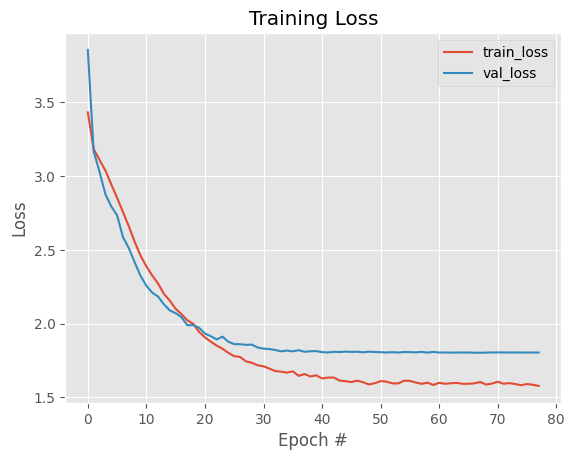

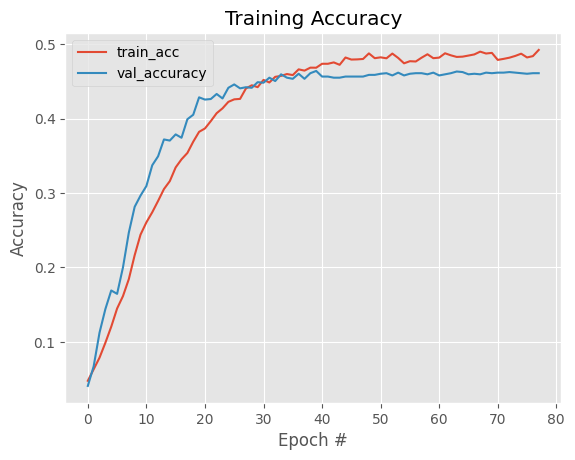

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.67      0.52      0.58        62
        down       0.19      0.11      0.14        62
       eight       0.64      0.81      0.71        62
        five       0.51      0.60      0.55        62
      follow       0.25      0.08      0.12        62
     forward       0.14      0.10      0.12        62
        four       0.36      0.24      0.29        62
          go       0.38      0.37      0.37        62
       learn       0.16      0.06      0.09        62
        left       0.61      0.63      0.62        62
        nine       0.19      0.56      0.29        62
          no       0.22      0.23      0.22        62
         off       0.77      0.60      0.67        62
          on       0.50      0.37      0.43        62
         one       0.22      0.32      0.26        62
       right       0.67      0.53      0.59        62
       seven       0.72      0.66      0.69       

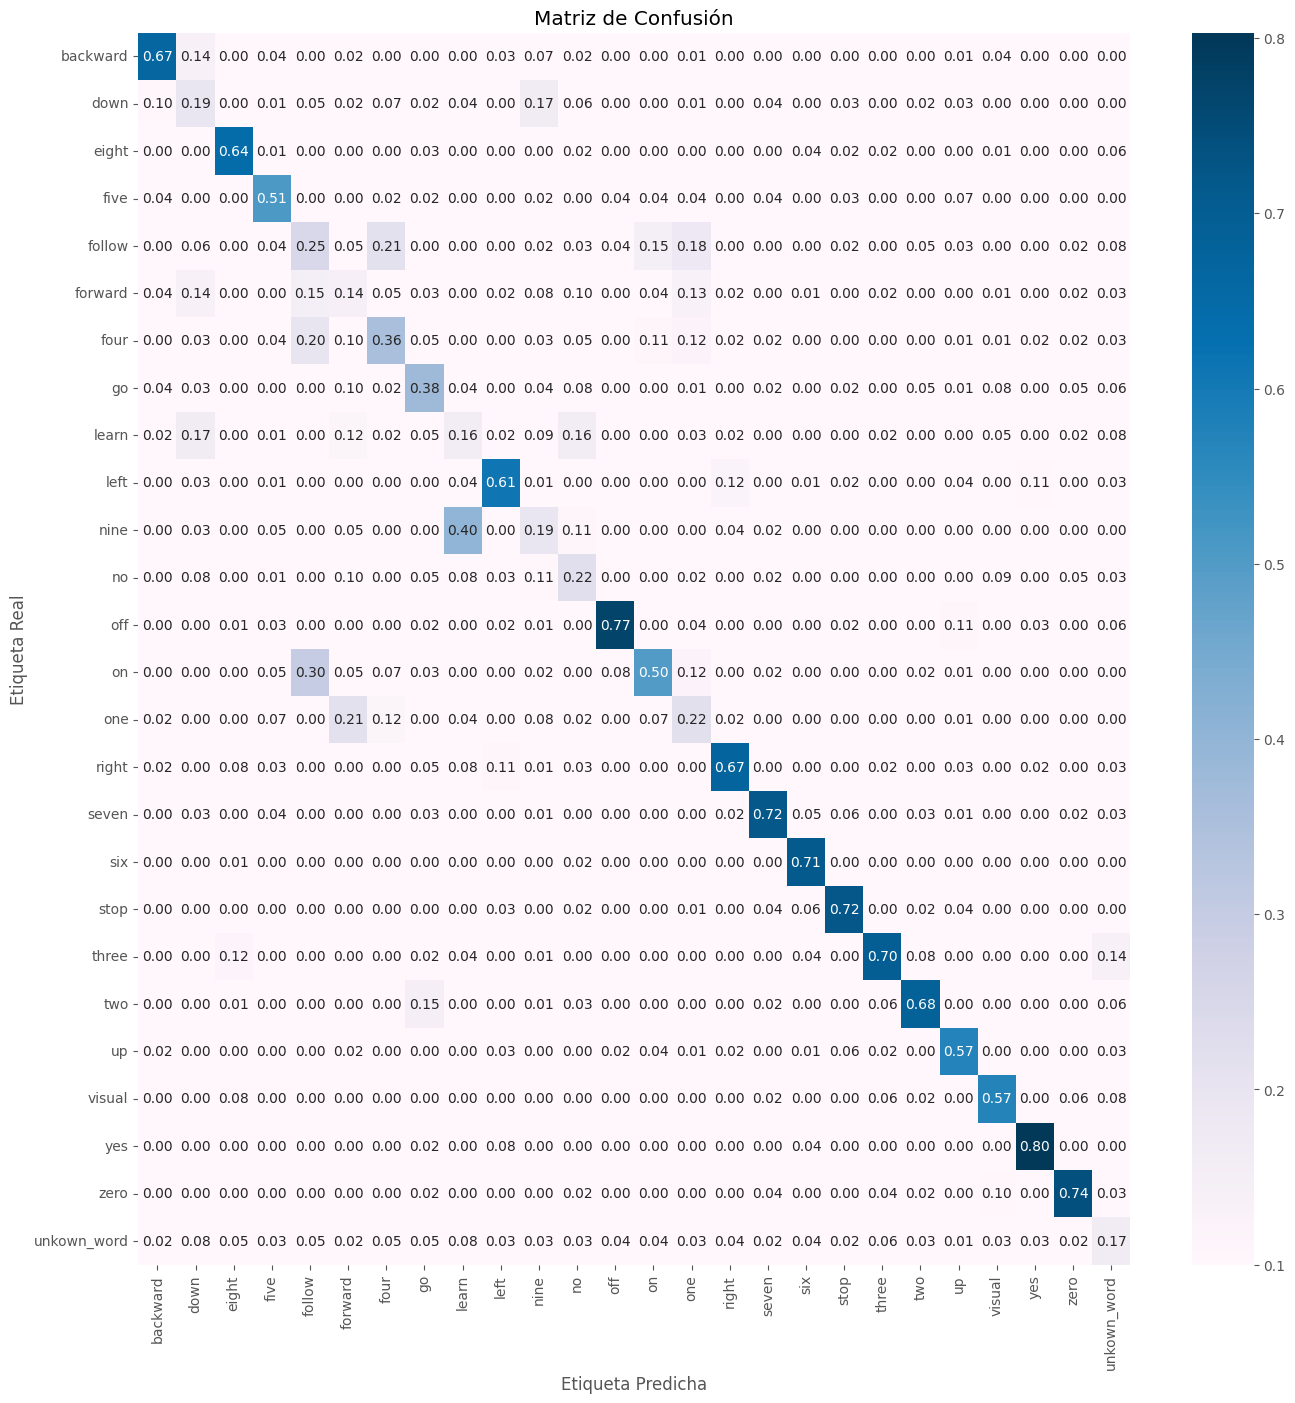

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_1_02, h_exp_a_cnn_lme_1_02, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_1_03

In [ ]:
exp_a_cnn_lme_1_03 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_1_03.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_1_03.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_1_03.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_1_03 = exp_a_cnn_lme_1_03.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0983 - loss: 3.0737
Epoch 1: val_loss improved from inf to 2.03222, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.0985 - loss: 3.0730 - val_accuracy: 0.3638 - val_loss: 2.0322 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3393 - loss: 2.1280
Epoch 2: val_loss improved from 2.03222 to 1.45296, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3399 - loss: 2.1260 - val_accuracy: 0.5683 - val_loss: 1.4530 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5060 - loss: 1.5699
Epoch 3: val_loss improved from 1.45296 to 1.07360, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5062 - loss: 1.5693 - val_accuracy: 0.6830 - val_loss: 1.0736 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6177 - loss: 1.2210
Epoch 4: val_loss improved from 1.07360 to 0.92201, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6178 - loss: 1.2203 - val_accuracy: 0.7147 - val_loss: 0.9220 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6698 - loss: 1.0158
Epoch 5: val_loss improved from 0.92201 to 0.85452, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6699 - loss: 1.0156 - val_accuracy: 0.7449 - val_loss: 0.8545 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7161 - loss: 0.8845
Epoch 6: val_loss improved from 0.85452 to 0.83184, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7162 - loss: 0.8842 - val_accuracy: 0.7449 - val_loss: 0.8318 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7408 - loss: 0.7934
Epoch 7: val_loss improved from 0.83184 to 0.79771, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7410 - loss: 0.7931 - val_accuracy: 0.7570 - val_loss: 0.7977 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7649 - loss: 0.7201
Epoch 8: val_loss improved from 0.79771 to 0.75271, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7651 - loss: 0.7194 - val_accuracy: 0.7781 - val_loss: 0.7527 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7941 - loss: 0.6369
Epoch 9: val_loss did not improve from 0.75271
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7941 - loss: 0.6366 - val_accuracy: 0.7766 - val_loss: 0.7680 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8170 - loss: 0.5701
Epoch 10: val_loss did not improve from 0.75271
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8170 - loss: 0.5700 - val_accuracy: 0.7796 - val_loss: 0.8078 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

In [ ]:
exp_a_cnn_lme_1_03.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 61, 126, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 61, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 14, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │         344,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,343,024 (5.12 MB)

 Trainable params: 447,674 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 895,350 (3.42 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


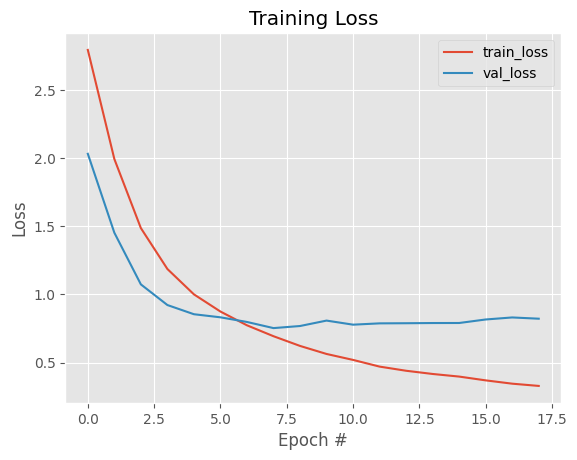

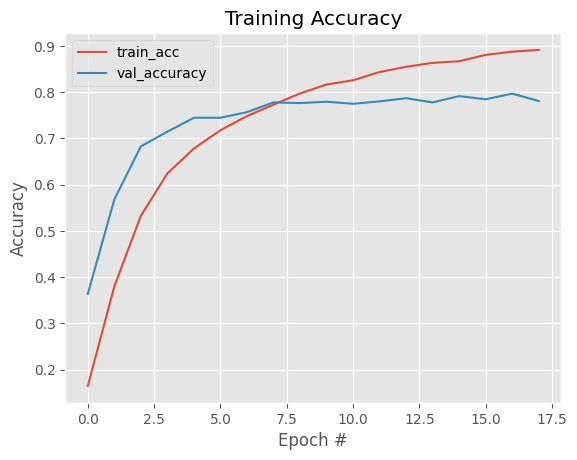

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.95      0.95      0.95        62
        down       0.81      0.76      0.78        62
       eight       0.84      0.90      0.87        62
        five       0.84      0.68      0.75        62
      follow       0.65      0.69      0.67        62
     forward       0.76      0.68      0.72        62
        four       0.72      0.66      0.69        62
          go       0.59      0.71      0.64        62
       learn       0.73      0.61      0.67        62
        left       0.86      0.71      0.78        62
        nine       0.84      0.85      0.85        62
          no       0.69      0.79      0.74        62
         off       0.80      0.77      0.79        62
          on       0.59      0.76      0.66        62
         one       0.76      0.84      0.80        62
       right       0.90      0.84      0.87        62
       seven       0.91      0.79      0.84       

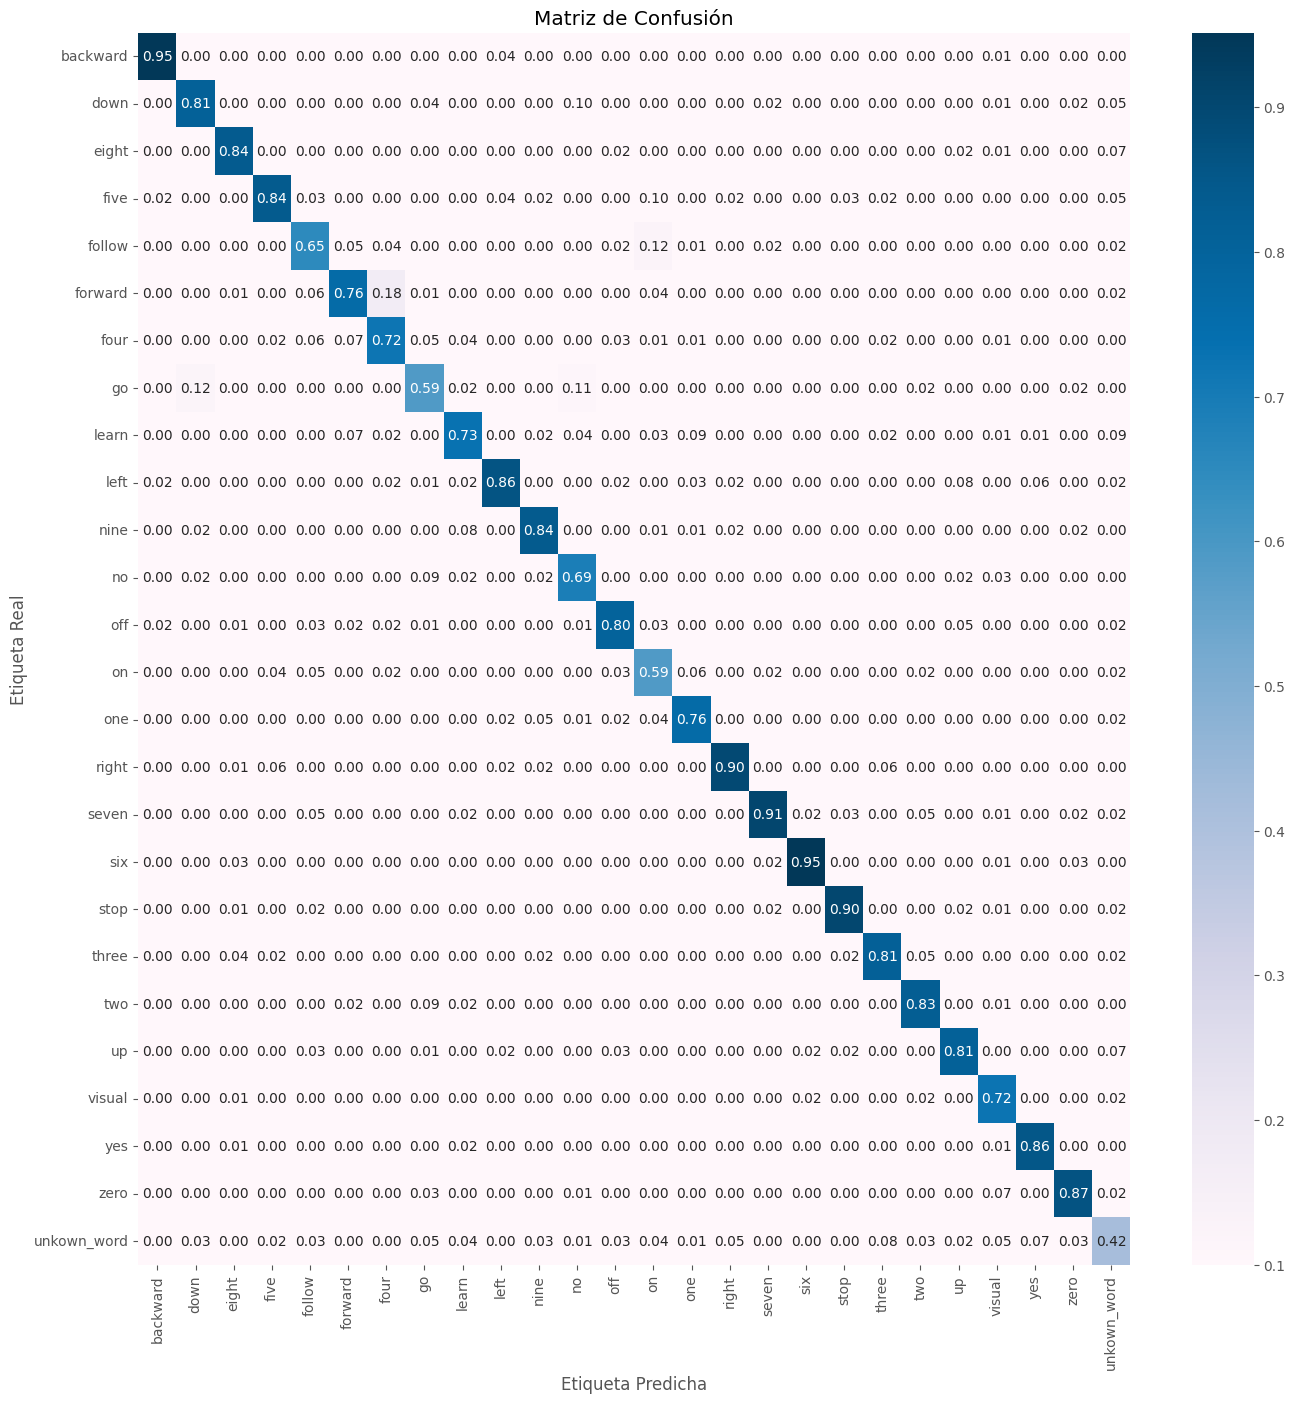

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_1_03, h_exp_a_cnn_lme_1_03, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_1_04

In [ ]:
exp_a_cnn_lme_1_04 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_1_04.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_1_04.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_1_04.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_1_04 = exp_a_cnn_lme_1_04.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1126 - loss: 3.0228
Epoch 1: val_loss improved from inf to 1.93079, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.1128 - loss: 3.0220 - val_accuracy: 0.4830 - val_loss: 1.9308 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4318 - loss: 1.8959
Epoch 2: val_loss improved from 1.93079 to 1.30878, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4324 - loss: 1.8938 - val_accuracy: 0.6279 - val_loss: 1.3088 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5718 - loss: 1.3923
Epoch 3: val_loss improved from 1.30878 to 1.01631, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5724 - loss: 1.3906 - val_accuracy: 0.7072 - val_loss: 1.0163 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6513 - loss: 1.1070
Epoch 4: val_loss improved from 1.01631 to 0.87776, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6515 - loss: 1.1066 - val_accuracy: 0.7479 - val_loss: 0.8778 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7024 - loss: 0.9562
Epoch 5: val_loss improved from 0.87776 to 0.79745, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7025 - loss: 0.9558 - val_accuracy: 0.7675 - val_loss: 0.7974 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7287 - loss: 0.8681
Epoch 6: val_loss improved from 0.79745 to 0.76975, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7287 - loss: 0.8680 - val_accuracy: 0.7698 - val_loss: 0.7697 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7490 - loss: 0.7756
Epoch 7: val_loss improved from 0.76975 to 0.72454, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7490 - loss: 0.7756 - val_accuracy: 0.7781 - val_loss: 0.7245 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7713 - loss: 0.7198
Epoch 8: val_loss improved from 0.72454 to 0.69519, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7713 - loss: 0.7198 - val_accuracy: 0.7947 - val_loss: 0.6952 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7771 - loss: 0.6777
Epoch 9: val_loss improved from 0.69519 to 0.69130, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7773 - loss: 0.6774 - val_accuracy: 0.7887 - val_loss: 0.6913 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7994 - loss: 0.6257
Epoch 10: val_loss improved from 0.69130 to 0.65577, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7995 - loss: 0.6254 - val_accuracy: 0.8023 - val_loss: 0.6558 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8098 - loss: 0.5815
Epoch 11: val_loss did not improve from 0.65577
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8098 - loss: 0.5815 - val_accuracy: 0.8008 - val_loss: 0.6638 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8153 - loss: 0.5559
Epoch 12: val_loss improved from 0.65577 to 0.64394, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8153 - loss: 0.5558 - val_accuracy: 0.8075 - val_loss: 0.6439 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8319 - loss: 0.5115
Epoch 13: val_loss improved from 0.64394 to 0.63568, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8319 - loss: 0.5115 - val_accuracy: 0.8106 - val_loss: 0.6357 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8330 - loss: 0.5171
Epoch 14: val_loss improved from 0.63568 to 0.63454, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8330 - loss: 0.5171 - val_accuracy: 0.8143 - val_loss: 0.6345 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8431 - loss: 0.4776
Epoch 15: val_loss did not improve from 0.63454
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8431 - loss: 0.4777 - val_accuracy: 0.8083 - val_loss: 0.6372 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8457 - loss: 0.4676
Epoch 16: val_loss did not improve from 0.63454
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8458 - loss: 0.4675 - val_accuracy: 0.8045 - val_loss: 0.6410 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8521 - loss: 0.4320 - val_accuracy: 0.8113 - val_loss: 0.6076 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8631 - loss: 0.4100
Epoch 19: val_loss did not improve from 0.60765
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8631 - loss: 0.4100 - val_accuracy: 0.8136 - val_loss: 0.6216 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8585 - loss: 0.4178
Epoch 20: val_loss did not improve from 0.60765
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8586 - loss: 0.4176 - val_accuracy: 0.8151 - val_loss: 0.6306 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8706 - loss: 0.3771 - val_accuracy: 0.8158 - val_loss: 0.6072 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8703 - loss: 0.3901
Epoch 23: val_loss did not improve from 0.60721
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8703 - loss: 0.3901 - val_accuracy: 0.8249 - val_loss: 0.6158 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8665 - loss: 0.3900
Epoch 24: val_loss improved from 0.60721 to 0.59790, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8667 - loss: 0.3897 - val_accuracy: 0.8242 - val_loss: 0.5979 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8788 - loss: 0.3610
Epoch 25: val_loss did not improve from 0.59790
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8788 - loss: 0.3609 - val_accuracy: 0.8234 - val_loss: 0.6057 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8779 - loss: 0.3638
Epoch 26: val_loss did not improve from 0.59790
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8779 - loss: 0.3638 - val_accuracy: 0.8249 - val_loss: 0.6122 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

In [ ]:
exp_a_cnn_lme_1_04.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 61, 126, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 61, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 14, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 6, 14, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         344,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,323,248 (5.05 MB)

 Trainable params: 441,082 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 882,166 (3.37 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


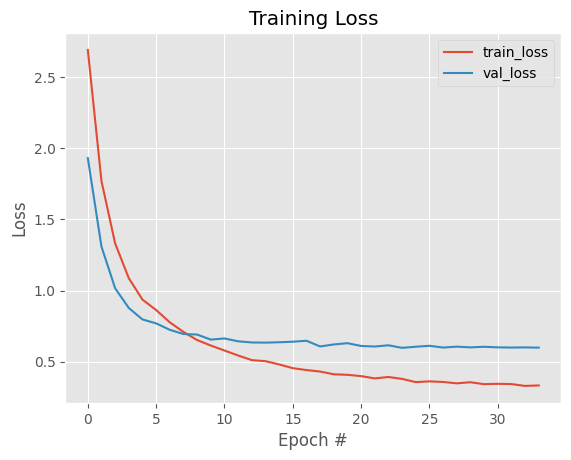

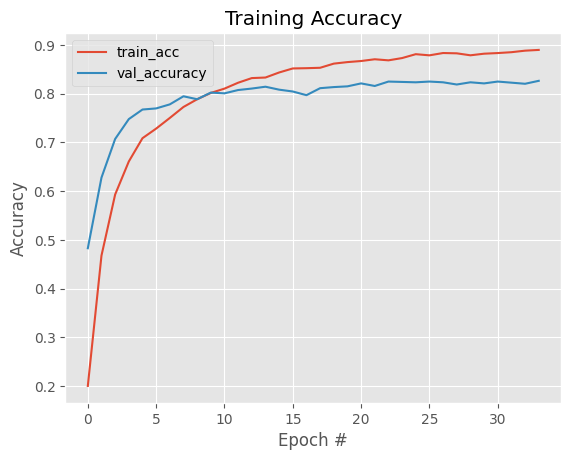

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.92      0.92      0.92        62
        down       0.87      0.74      0.80        62
       eight       0.93      0.92      0.93        62
        five       0.84      0.84      0.84        62
      follow       0.77      0.77      0.77        62
     forward       0.76      0.76      0.76        62
        four       0.82      0.73      0.77        62
          go       0.71      0.89      0.79        62
       learn       0.80      0.79      0.80        62
        left       0.88      0.81      0.84        62
        nine       0.81      0.90      0.85        62
          no       0.79      0.94      0.86        62
         off       0.84      0.74      0.79        62
          on       0.73      0.76      0.75        62
         one       0.89      0.87      0.88        62
       right       0.93      0.89      0.91        62
       seven       0.93      0.82      0.87       

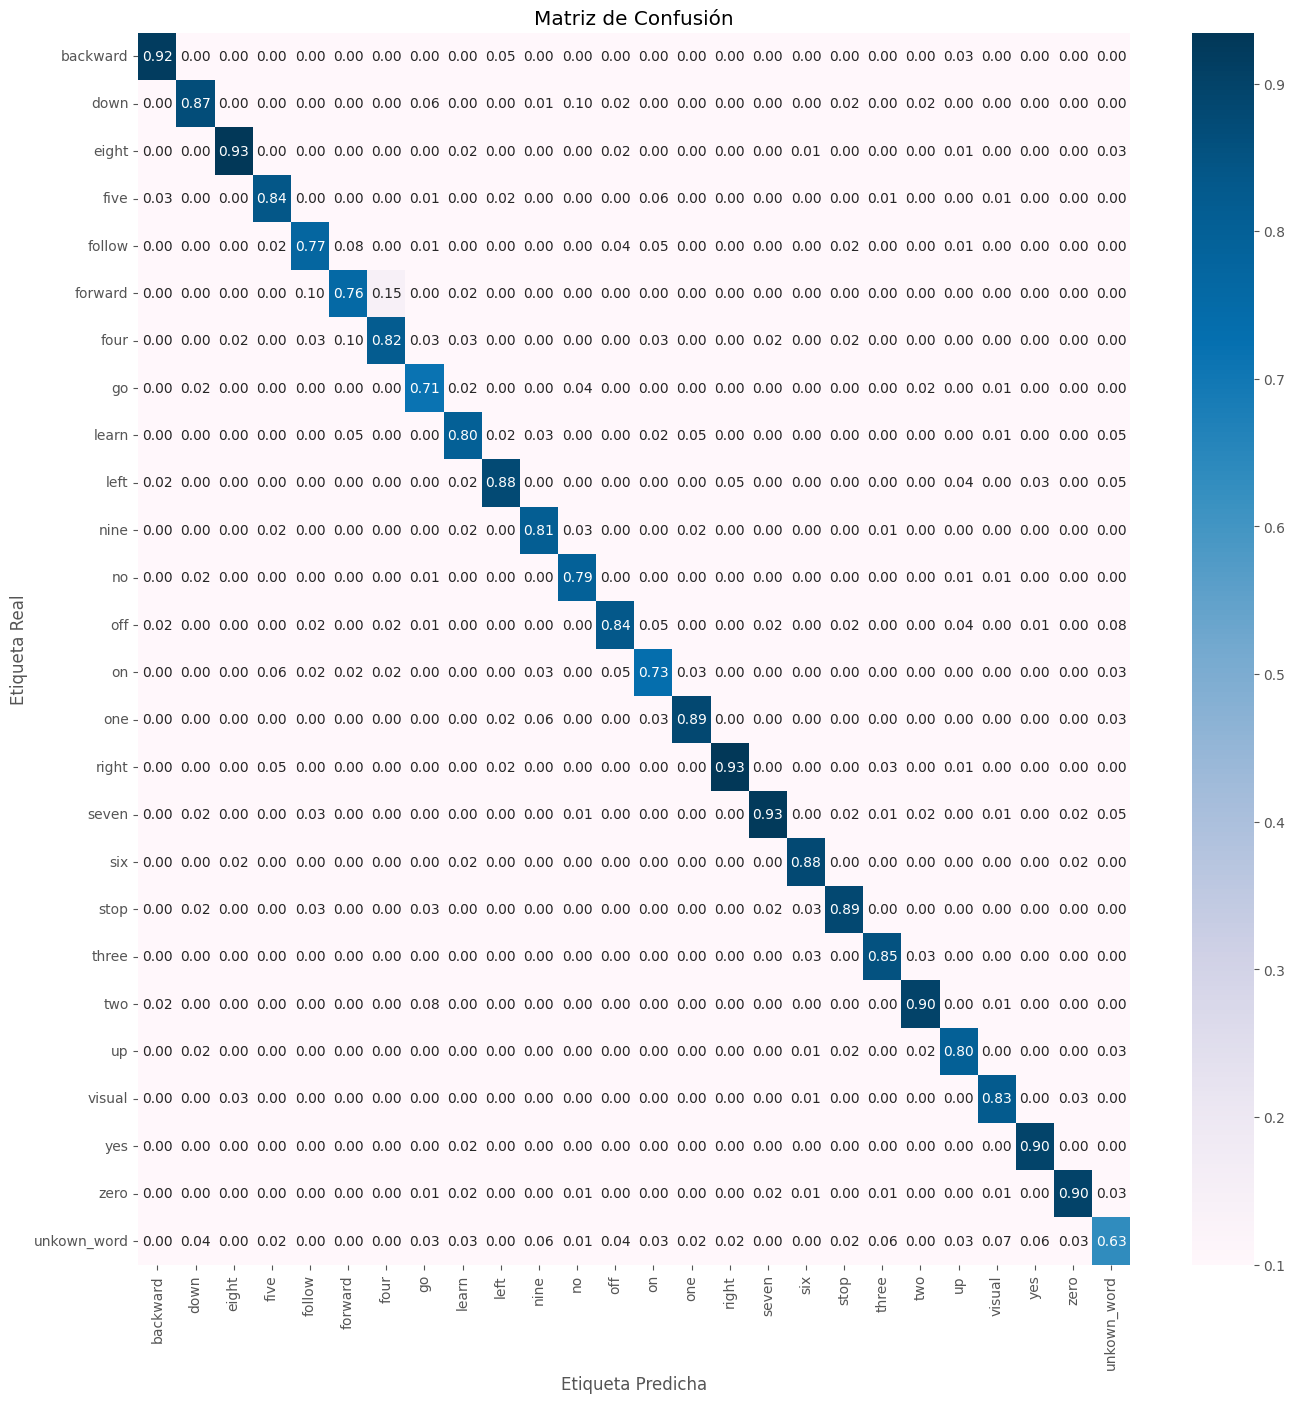

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_1_04, h_exp_a_cnn_lme_1_04, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_1_05

In [ ]:
exp_a_cnn_lme_1_05 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),

    # Capa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_1_05.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_1_05.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_1_05.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_1_05 = exp_a_cnn_lme_1_05.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0789 - loss: 3.2927
Epoch 1: val_loss improved from inf to 3.67429, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.0789 - loss: 3.2921 - val_accuracy: 0.1464 - val_loss: 3.6743 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2183 - loss: 2.6239
Epoch 2: val_loss improved from 3.67429 to 2.01583, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2187 - loss: 2.6224 - val_accuracy: 0.4113 - val_loss: 2.0158 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3406 - loss: 2.1681
Epoch 3: val_loss improved from 2.01583 to 1.83230, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3408 - loss: 2.1673 - val_accuracy: 0.4460 - val_loss: 1.8323 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4547 - loss: 1.7532
Epoch 4: val_loss improved from 1.83230 to 1.28984, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4547 - loss: 1.7530 - val_accuracy: 0.6294 - val_loss: 1.2898 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5370 - loss: 1.4603
Epoch 5: val_loss improved from 1.28984 to 1.15271, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5370 - loss: 1.4602 - val_accuracy: 0.6604 - val_loss: 1.1527 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5981 - loss: 1.2709
Epoch 6: val_loss improved from 1.15271 to 0.94708, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5983 - loss: 1.2704 - val_accuracy: 0.7185 - val_loss: 0.9471 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6551 - loss: 1.0883
Epoch 7: val_loss improved from 0.94708 to 0.82396, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6552 - loss: 1.0882 - val_accuracy: 0.7585 - val_loss: 0.8240 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6839 - loss: 0.9895
Epoch 8: val_loss did not improve from 0.82396
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6840 - loss: 0.9894 - val_accuracy: 0.7140 - val_loss: 1.0064 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7132 - loss: 0.8832
Epoch 9: val_loss improved from 0.82396 to 0.73604, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7133 - loss: 0.8831 - val_accuracy: 0.7834 - val_loss: 0.7360 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7483 - loss: 0.7777
Epoch 10: val_loss did not improve from 0.73604
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7483 - loss: 0.7778 - val_accuracy: 0.7811 - val_loss: 0.7546 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7668 - loss: 0.7250
Epoch 11: val_loss improved from 0.73604 to 0.63549, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7669 - loss: 0.7247 - val_accuracy: 0.8113 - val_loss: 0.6355 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7899 - loss: 0.6535
Epoch 12: val_loss did not improve from 0.63549
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7900 - loss: 0.6535 - val_accuracy: 0.7947 - val_loss: 0.6961 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8066 - loss: 0.6057
Epoch 13: val_loss improved from 0.63549 to 0.60391, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8066 - loss: 0.6056 - val_accuracy: 0.8309 - val_loss: 0.6039 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8209 - loss: 0.5445
Epoch 14: val_loss did not improve from 0.60391
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8209 - loss: 0.5446 - val_accuracy: 0.8121 - val_loss: 0.6483 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8292 - loss: 0.5251
Epoch 15: val_loss improved from 0.60391 to 0.59022, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8293 - loss: 0.5248 - val_accuracy: 0.8264 - val_loss: 0.5902 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8317 - loss: 0.4976
Epoch 16: val_loss did not improve from 0.59022
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8318 - loss: 0.4973 - val_accuracy: 0.8272 - val_loss: 0.5906 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8465 - loss: 0.4654
Epoch 17: val_loss improved from 0.59022 to 0.58698, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8466 - loss: 0.4652 - val_accuracy: 0.8370 - val_loss: 0.5870 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8582 - loss: 0.4344
Epoch 18: val_loss improved from 0.58698 to 0.57620, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8582 - loss: 0.4344 - val_accuracy: 0.8332 - val_loss: 0.5762 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8640 - loss: 0.4099
Epoch 19: val_loss improved from 0.57620 to 0.57422, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8640 - loss: 0.4099 - val_accuracy: 0.8377 - val_loss: 0.5742 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8696 - loss: 0.4058
Epoch 20: val_loss improved from 0.57422 to 0.56828, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8695 - loss: 0.4057 - val_accuracy: 0.8370 - val_loss: 0.5683 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8752 - loss: 0.3708
Epoch 21: val_loss did not improve from 0.56828
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8752 - loss: 0.3708 - val_accuracy: 0.8423 - val_loss: 0.5707 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8774 - loss: 0.3735
Epoch 22: val_loss did not improve from 0.56828
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8774 - loss: 0.3734 - val_accuracy: 0.8400 - val_loss: 0.5881 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8825 - loss: 0.3521 - val_accuracy: 0.8408 - val_loss: 0.5530 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8953 - loss: 0.3221
Epoch 25: val_loss improved from 0.55295 to 0.55114, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8953 - loss: 0.3221 - val_accuracy: 0.8430 - val_loss: 0.5511 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8864 - loss: 0.3278
Epoch 26: val_loss improved from 0.55114 to 0.54661, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8864 - loss: 0.3278 - val_accuracy: 0.8400 - val_loss: 0.5466 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8907 - loss: 0.3213
Epoch 27: val_loss improved from 0.54661 to 0.54391, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8907 - loss: 0.3212 - val_accuracy: 0.8430 - val_loss: 0.5439 - learning_rate: 6.4611e-05

Epoch 28: LearningRateScheduler setting learning rate to 5.8149737003040094e-05.
Epoch 28/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8996 - loss: 0.3117
Epoch 28: val_loss did not improve from 0.54391
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8996 - loss: 0.3118 - val_accuracy: 0.8438 - val_loss: 0.5467 - learning_rate: 5.8150e-05

Epoch 29: LearningRateScheduler setting learning rate to 5.233476330273609e-05.
Epoch 29/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9047 - loss: 0.2955
Epoch 29: val_loss improved from 0.54391 to 0.54324, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9047 - loss: 0.2956 - val_accuracy: 0.8430 - val_loss: 0.5432 - learning_rate: 5.2335e-05

Epoch 30: LearningRateScheduler setting learning rate to 4.7101286972462485e-05.
Epoch 30/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9039 - loss: 0.2961
Epoch 30: val_loss did not improve from 0.54324
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9038 - loss: 0.2963 - val_accuracy: 0.8430 - val_loss: 0.5508 - learning_rate: 4.7101e-05

Epoch 31: LearningRateScheduler setting learning rate to 4.239115827521624e-05.
Epoch 31/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8952 - loss: 0.3120
Epoch 31: val_loss improved from 0.54324 to 0.54075, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8952 - loss: 0.3120 - val_accuracy: 0.8430 - val_loss: 0.5408 - learning_rate: 4.2391e-05

Epoch 32: LearningRateScheduler setting learning rate to 3.8152042447694614e-05.
Epoch 32/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9065 - loss: 0.2903
Epoch 32: val_loss did not improve from 0.54075
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9065 - loss: 0.2904 - val_accuracy: 0.8430 - val_loss: 0.5410 - learning_rate: 3.8152e-05

Epoch 33: LearningRateScheduler setting learning rate to 3.433683820292515e-05.
Epoch 33/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9020 - loss: 0.2880
Epoch 33: val_loss did not improve from 0.54075
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9020 - loss: 0.2880 - val_accuracy: 0.8438 - val_loss: 0.5409 - learning_rate: 3.4337e-05

Epoch 34: LearningRateScheduler setting learning rate to 3.090315438263264e-05.
Epoch 34/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9062 - loss: 0.2743 - val_accuracy: 0.8438 - val_loss: 0.5363 - learning_rate: 2.7813e-05

Epoch 36: LearningRateScheduler setting learning rate to 2.5031555049932436e-05.
Epoch 36/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9056 - loss: 0.2838
Epoch 36: val_loss did not improve from 0.53628
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9056 - loss: 0.2838 - val_accuracy: 0.8415 - val_loss: 0.5376 - learning_rate: 2.5032e-05

Epoch 37: LearningRateScheduler setting learning rate to 2.2528399544939195e-05.
Epoch 37/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9069 - loss: 0.2806
Epoch 37: val_loss did not improve from 0.53628
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9069 - loss: 0.2806 - val_accuracy: 0.8423 - val_loss: 0.5396 - learning_rate: 2.2528e-05

Epoch 38: LearningRateScheduler setting learning rate to 2.0275559590445276e-05.
Epoch 38/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

In [ ]:
exp_a_cnn_lme_1_05.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 61, 126, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 61, 126, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 61, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 12, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 6, 14, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 6, 14, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         344,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,325,040 (5.05 MB)

 Trainable params: 441,530 (1.68 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 883,062 (3.37 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


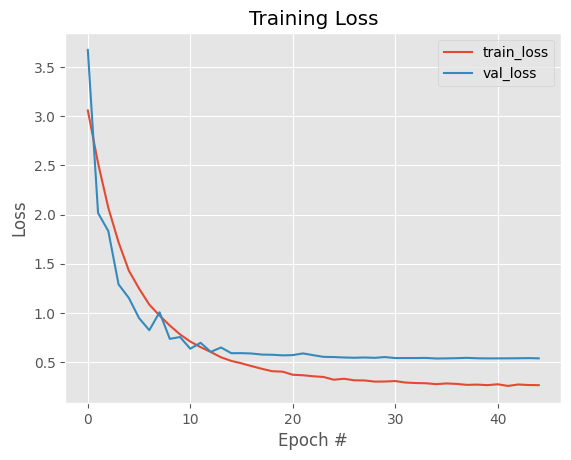

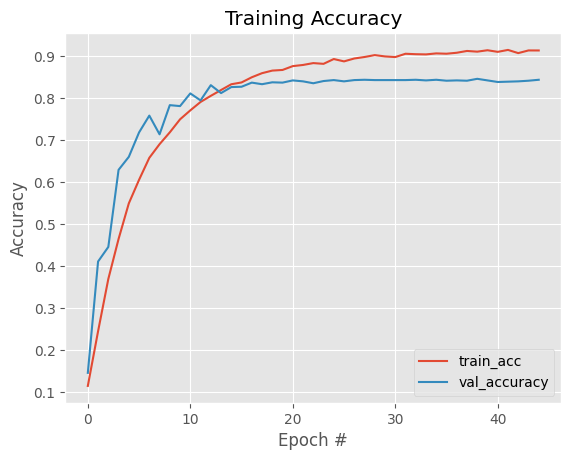

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.91      0.97      0.94        62
        down       0.93      0.82      0.87        62
       eight       0.89      0.90      0.90        62
        five       0.83      0.92      0.87        62
      follow       0.84      0.82      0.83        62
     forward       0.86      0.71      0.78        62
        four       0.73      0.85      0.79        62
          go       0.79      0.85      0.82        62
       learn       0.78      0.74      0.76        62
        left       0.95      0.90      0.93        62
        nine       0.89      0.90      0.90        62
          no       0.76      0.89      0.82        62
         off       0.88      0.84      0.86        62
          on       0.81      0.90      0.85        62
         one       0.96      0.82      0.89        62
       right       0.97      0.92      0.94        62
       seven       0.92      0.87      0.89       

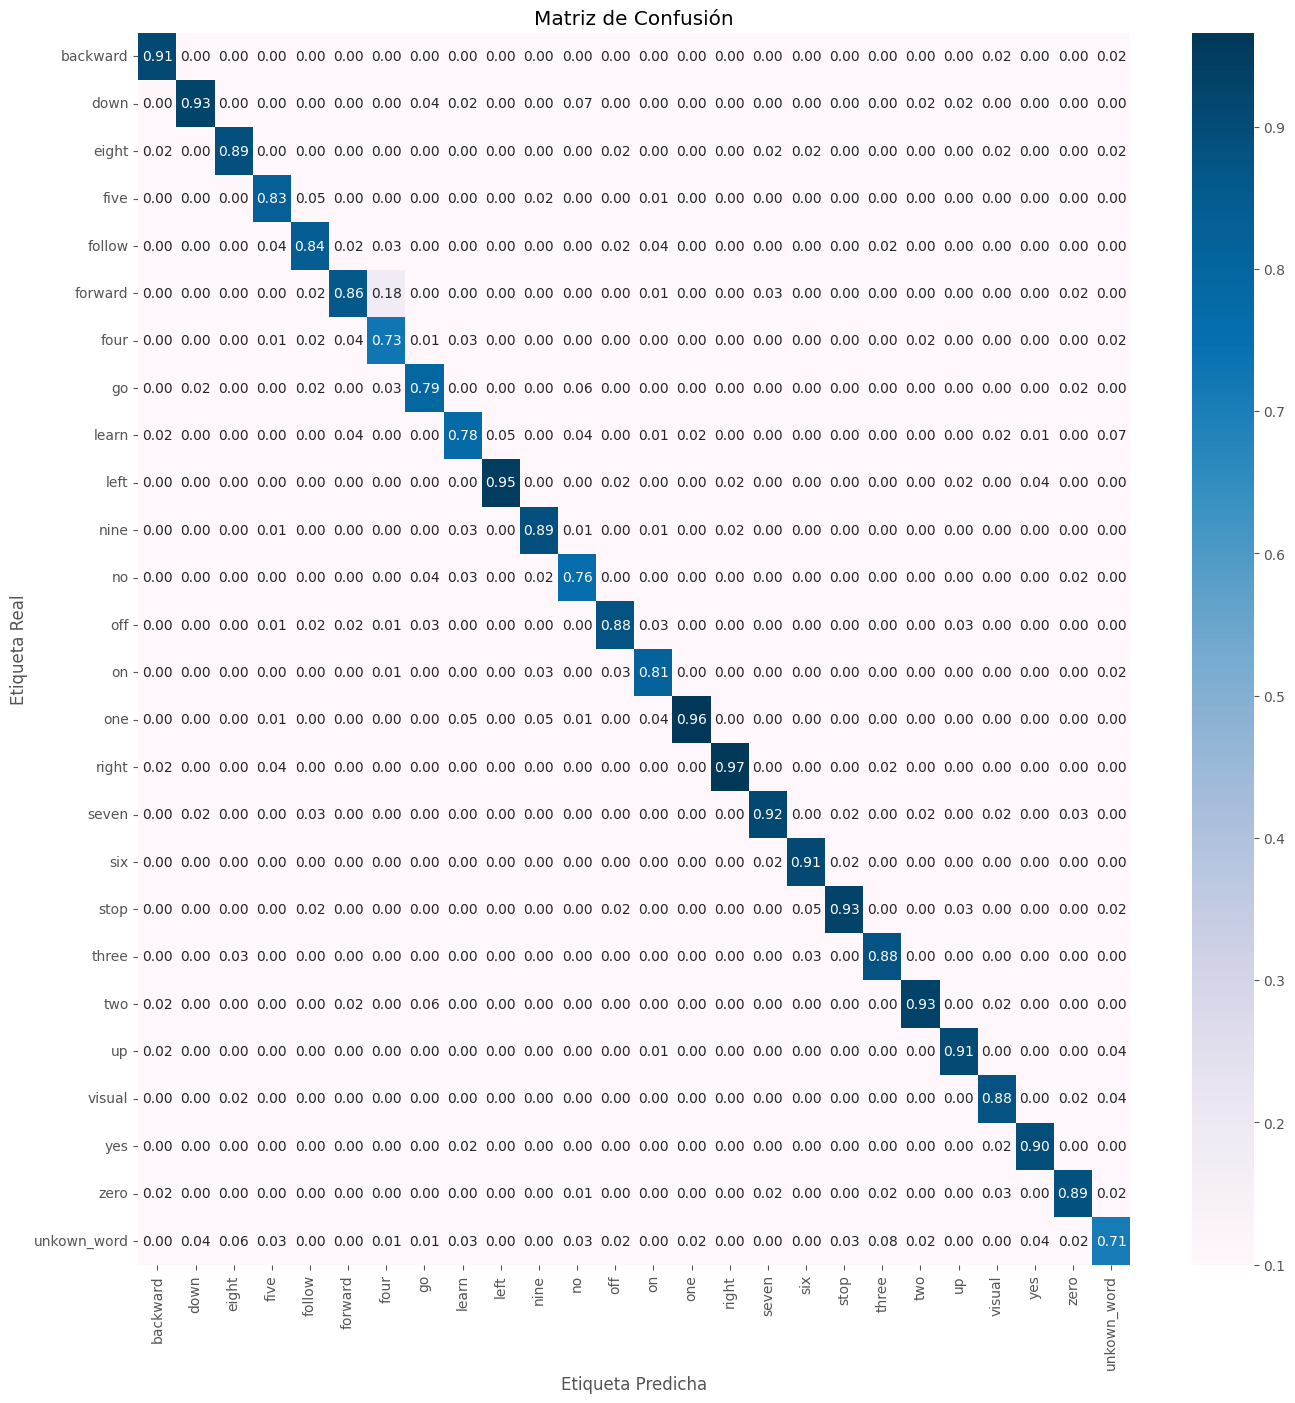

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_1_05, h_exp_a_cnn_lme_1_05, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_1_06

In [ ]:
exp_a_cnn_lme_1_06 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),  # Aplanar para pasar a capas densas

    # Capa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_1_06.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_1_06.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_1_06.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_1_06 = exp_a_cnn_lme_1_06.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1283 - loss: 3.1875
Epoch 1: val_loss improved from inf to 2.17847, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.1285 - loss: 3.1865 - val_accuracy: 0.3306 - val_loss: 2.1785 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3921 - loss: 2.0042
Epoch 2: val_loss improved from 2.17847 to 1.69091, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3925 - loss: 2.0026 - val_accuracy: 0.4989 - val_loss: 1.6909 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5333 - loss: 1.5016
Epoch 3: val_loss improved from 1.69091 to 1.13083, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5335 - loss: 1.5008 - val_accuracy: 0.6672 - val_loss: 1.1308 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6305 - loss: 1.1709
Epoch 4: val_loss improved from 1.13083 to 0.98317, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6306 - loss: 1.1707 - val_accuracy: 0.7049 - val_loss: 0.9832 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6912 - loss: 0.9574
Epoch 5: val_loss improved from 0.98317 to 0.88719, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6915 - loss: 0.9568 - val_accuracy: 0.7306 - val_loss: 0.8872 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7404 - loss: 0.7988
Epoch 6: val_loss improved from 0.88719 to 0.76312, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7404 - loss: 0.7986 - val_accuracy: 0.7645 - val_loss: 0.7631 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7750 - loss: 0.6793
Epoch 7: val_loss improved from 0.76312 to 0.69978, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7750 - loss: 0.6792 - val_accuracy: 0.7947 - val_loss: 0.6998 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8060 - loss: 0.5980
Epoch 8: val_loss improved from 0.69978 to 0.65135, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8059 - loss: 0.5980 - val_accuracy: 0.7932 - val_loss: 0.6513 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8279 - loss: 0.5257
Epoch 9: val_loss improved from 0.65135 to 0.64791, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8280 - loss: 0.5255 - val_accuracy: 0.7977 - val_loss: 0.6479 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8514 - loss: 0.4510
Epoch 10: val_loss improved from 0.64791 to 0.62170, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8514 - loss: 0.4510 - val_accuracy: 0.8143 - val_loss: 0.6217 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8664 - loss: 0.4165
Epoch 11: val_loss did not improve from 0.62170
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8664 - loss: 0.4163 - val_accuracy: 0.8098 - val_loss: 0.6584 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8754 - loss: 0.3803
Epoch 12: val_loss did not improve from 0.62170
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8754 - loss: 0.3803 - val_accuracy: 0.8151 - val_loss: 0.6412 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9030 - loss: 0.2989 - val_accuracy: 0.8234 - val_loss: 0.6216 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9106 - loss: 0.2704
Epoch 15: val_loss did not improve from 0.62156
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9106 - loss: 0.2703 - val_accuracy: 0.8128 - val_loss: 0.6687 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9154 - loss: 0.2535
Epoch 16: val_loss did not improve from 0.62156
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9154 - loss: 0.2535 - val_accuracy: 0.8264 - val_loss: 0.6314 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9319 - loss: 0.2063 - val_accuracy: 0.8340 - val_loss: 0.6192 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9344 - loss: 0.1912
Epoch 20: val_loss did not improve from 0.61923
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9344 - loss: 0.1912 - val_accuracy: 0.8415 - val_loss: 0.6204 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9424 - loss: 0.1738
Epoch 21: val_loss did not improve from 0.61923
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9424 - loss: 0.1739 - val_accuracy: 0.8423 - val_loss: 0.6358 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9491 - loss: 0.1634 - val_accuracy: 0.8430 - val_loss: 0.6186 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9496 - loss: 0.1518
Epoch 24: val_loss improved from 0.61858 to 0.61326, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9496 - loss: 0.1519 - val_accuracy: 0.8423 - val_loss: 0.6133 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9553 - loss: 0.1395
Epoch 25: val_loss improved from 0.61326 to 0.60959, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9552 - loss: 0.1395 - val_accuracy: 0.8445 - val_loss: 0.6096 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9555 - loss: 0.1385
Epoch 26: val_loss did not improve from 0.60959
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9555 - loss: 0.1385 - val_accuracy: 0.8438 - val_loss: 0.6184 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9565 - loss: 0.1335
Epoch 27: val_loss did not improve from 0.60959
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9565 - loss: 0.1335 - val_accuracy: 0.8430 - val_loss: 0.6214 - learning_rate: 6.4611e-05

Epoch 28: LearningRateScheduler setting learning rate to 5.8149737003040094e-05.
Epoch 28/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9595 - loss: 0.1270 - val_accuracy: 0.8506 - val_loss: 0.6091 - learning_rate: 5.8150e-05

Epoch 29: LearningRateScheduler setting learning rate to 5.233476330273609e-05.
Epoch 29/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9579 - loss: 0.1307
Epoch 29: val_loss did not improve from 0.60909
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9579 - loss: 0.1306 - val_accuracy: 0.8423 - val_loss: 0.6217 - learning_rate: 5.2335e-05

Epoch 30: LearningRateScheduler setting learning rate to 4.7101286972462485e-05.
Epoch 30/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9606 - loss: 0.1224
Epoch 30: val_loss did not improve from 0.60909
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9606 - loss: 0.1224 - val_accuracy: 0.8475 - val_loss: 0.6204 - learning_rate: 4.7101e-05

Epoch 31: LearningRateScheduler setting learning rate to 4.239115827521624e-05.
Epoch 31/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

In [ ]:
exp_a_cnn_lme_1_06.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 61, 126, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 61, 126, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 28, 61, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 28, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 12, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 6, 14, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 6, 14, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │         344,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,325,040 (5.05 MB)

 Trainable params: 441,530 (1.68 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 883,062 (3.37 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


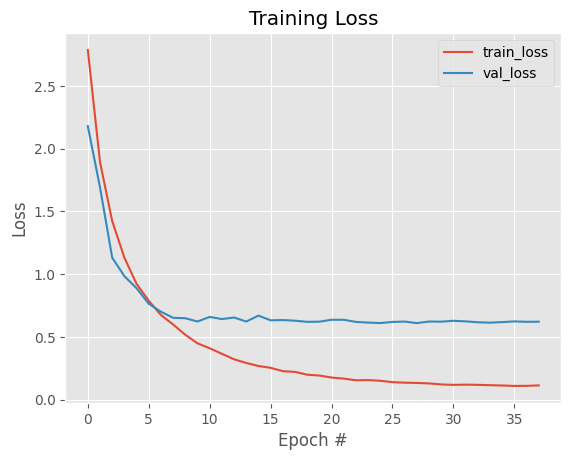

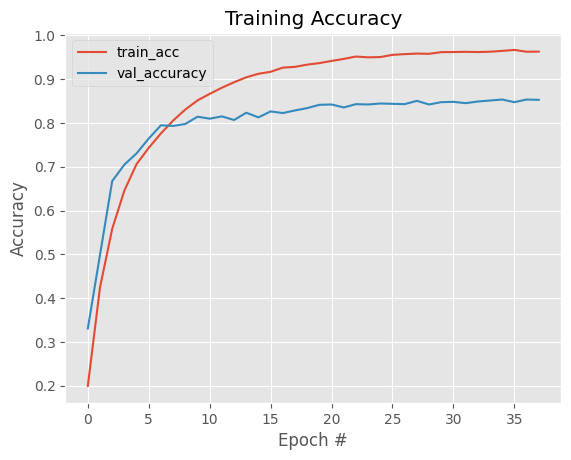

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.95      0.97      0.96        62
        down       0.89      0.77      0.83        62
       eight       0.92      0.90      0.91        62
        five       0.89      0.92      0.90        62
      follow       0.73      0.84      0.78        62
     forward       0.75      0.74      0.75        62
        four       0.73      0.76      0.75        62
          go       0.76      0.85      0.80        62
       learn       0.79      0.87      0.83        62
        left       1.00      0.87      0.93        62
        nine       0.90      0.90      0.90        62
          no       0.85      0.94      0.89        62
         off       0.89      0.82      0.86        62
          on       0.86      0.89      0.87        62
         one       0.92      0.87      0.89        62
       right       0.95      0.90      0.93        62
       seven       0.98      0.87      0.92       

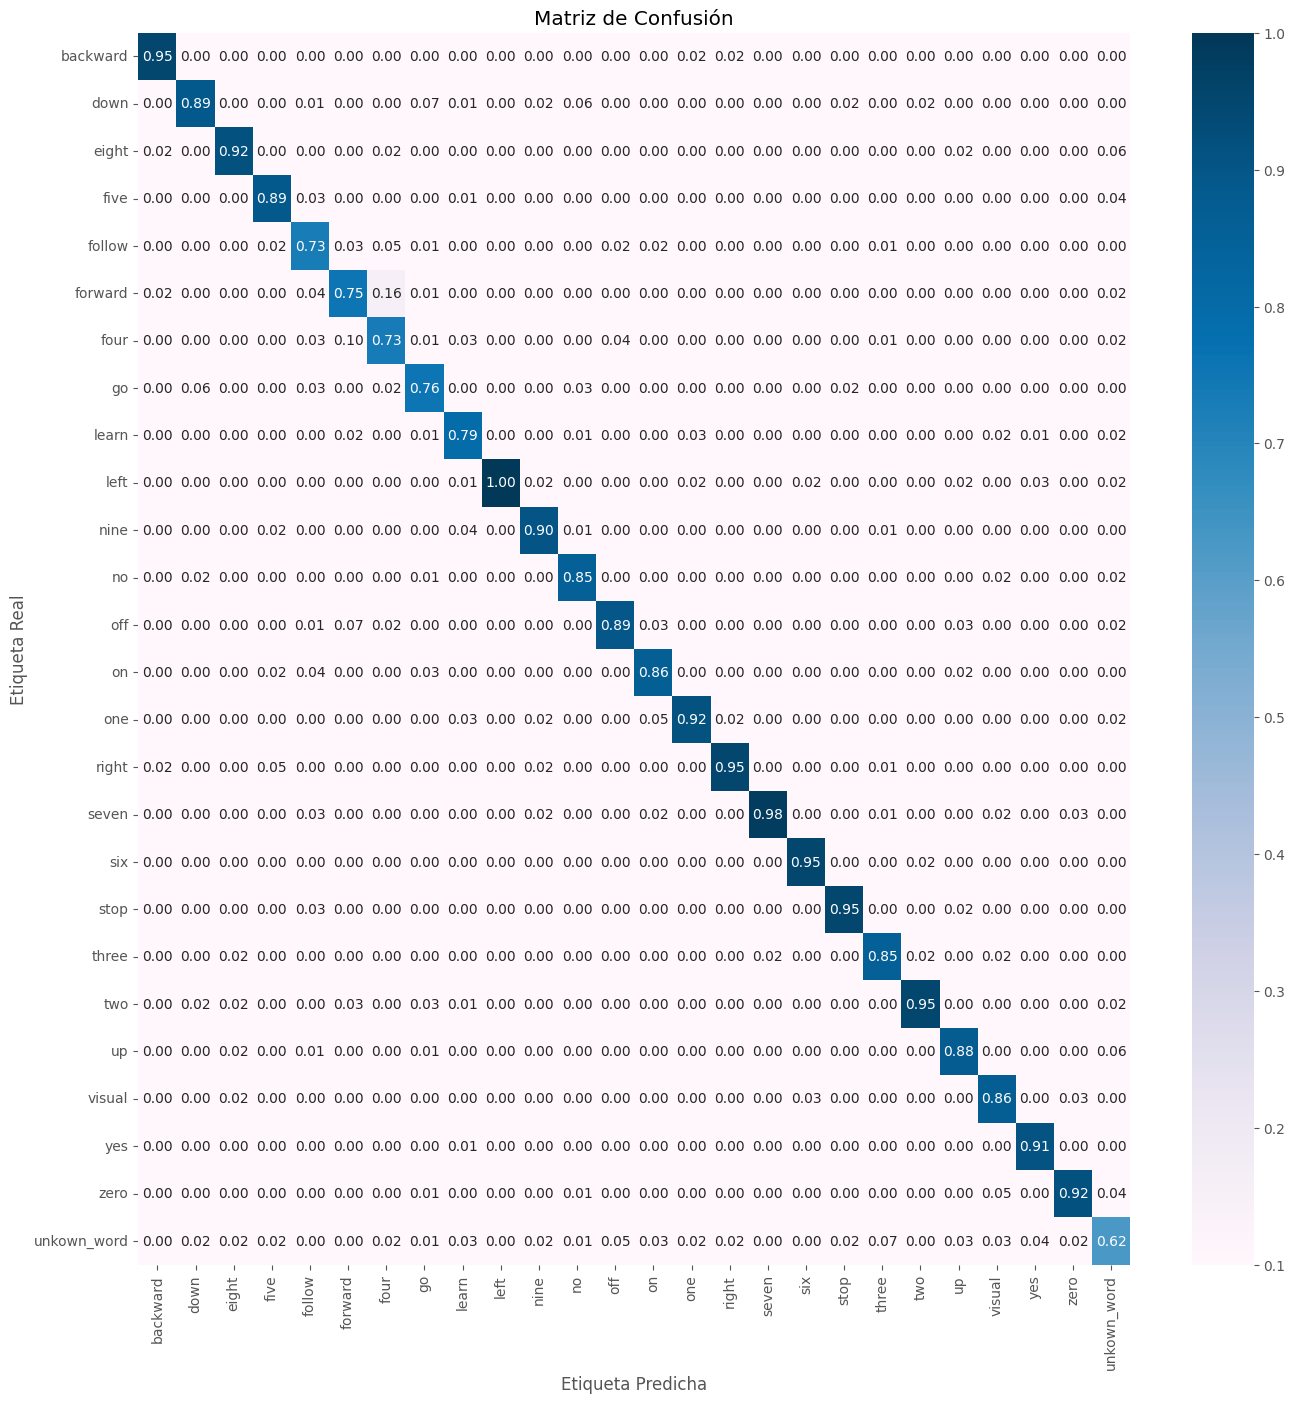

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_1_06, h_exp_a_cnn_lme_1_06, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_1_07

In [ ]:
exp_a_cnn_lme_1_07 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),  # Aplanar para pasar a capas densas

    # Capa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_1_07.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_1_07.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_1_07.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_1_07 = exp_a_cnn_lme_1_07.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0807 - loss: 3.2762
Epoch 1: val_loss improved from inf to 2.58155, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.0808 - loss: 3.2756 - val_accuracy: 0.2234 - val_loss: 2.5816 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2572 - loss: 2.4771
Epoch 2: val_loss improved from 2.58155 to 1.90426, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2577 - loss: 2.4748 - val_accuracy: 0.4475 - val_loss: 1.9043 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3788 - loss: 1.9893
Epoch 3: val_loss improved from 1.90426 to 1.85188, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3790 - loss: 1.9886 - val_accuracy: 0.4219 - val_loss: 1.8519 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4822 - loss: 1.6211
Epoch 4: val_loss improved from 1.85188 to 1.34963, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4823 - loss: 1.6210 - val_accuracy: 0.6023 - val_loss: 1.3496 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5732 - loss: 1.3521
Epoch 5: val_loss improved from 1.34963 to 0.95679, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5735 - loss: 1.3512 - val_accuracy: 0.7162 - val_loss: 0.9568 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6389 - loss: 1.1235
Epoch 6: val_loss improved from 0.95679 to 0.93002, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6389 - loss: 1.1234 - val_accuracy: 0.7079 - val_loss: 0.9300 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6883 - loss: 0.9788
Epoch 7: val_loss improved from 0.93002 to 0.76090, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6884 - loss: 0.9786 - val_accuracy: 0.7562 - val_loss: 0.7609 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7112 - loss: 0.8842
Epoch 8: val_loss improved from 0.76090 to 0.73298, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7113 - loss: 0.8838 - val_accuracy: 0.7811 - val_loss: 0.7330 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7424 - loss: 0.7934
Epoch 9: val_loss improved from 0.73298 to 0.69088, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7424 - loss: 0.7934 - val_accuracy: 0.7977 - val_loss: 0.6909 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7712 - loss: 0.7086
Epoch 10: val_loss improved from 0.69088 to 0.68654, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7713 - loss: 0.7086 - val_accuracy: 0.7894 - val_loss: 0.6865 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7937 - loss: 0.6310
Epoch 11: val_loss improved from 0.68654 to 0.65570, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7937 - loss: 0.6311 - val_accuracy: 0.8060 - val_loss: 0.6557 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8080 - loss: 0.5943
Epoch 12: val_loss improved from 0.65570 to 0.62575, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8080 - loss: 0.5942 - val_accuracy: 0.8264 - val_loss: 0.6257 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8154 - loss: 0.5571
Epoch 13: val_loss improved from 0.62575 to 0.61207, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8155 - loss: 0.5569 - val_accuracy: 0.8234 - val_loss: 0.6121 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8395 - loss: 0.5023
Epoch 14: val_loss did not improve from 0.61207
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8394 - loss: 0.5024 - val_accuracy: 0.8060 - val_loss: 0.6757 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8427 - loss: 0.4791
Epoch 15: val_loss did not improve from 0.61207
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8427 - loss: 0.4792 - val_accuracy: 0.8264 - val_loss: 0.6239 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8537 - loss: 0.4434 - val_accuracy: 0.8264 - val_loss: 0.6021 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8566 - loss: 0.4342
Epoch 17: val_loss did not improve from 0.60213
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8566 - loss: 0.4341 - val_accuracy: 0.8226 - val_loss: 0.6421 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8787 - loss: 0.3834
Epoch 18: val_loss improved from 0.60213 to 0.59682, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8786 - loss: 0.3836 - val_accuracy: 0.8355 - val_loss: 0.5968 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8773 - loss: 0.3773
Epoch 19: val_loss did not improve from 0.59682
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8773 - loss: 0.3773 - val_accuracy: 0.8347 - val_loss: 0.6094 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8764 - loss: 0.3739
Epoch 20: val_loss did not improve from 0.59682
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8764 - loss: 0.3739 - val_accuracy: 0.8377 - val_loss: 0.6018 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

In [ ]:
exp_a_cnn_lme_1_07.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 61, 126, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 61, 126, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 28, 61, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 28, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 12, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 12, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 6, 14, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 6, 14, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │         344,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,344,816 (5.13 MB)

 Trainable params: 448,122 (1.71 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 896,246 (3.42 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


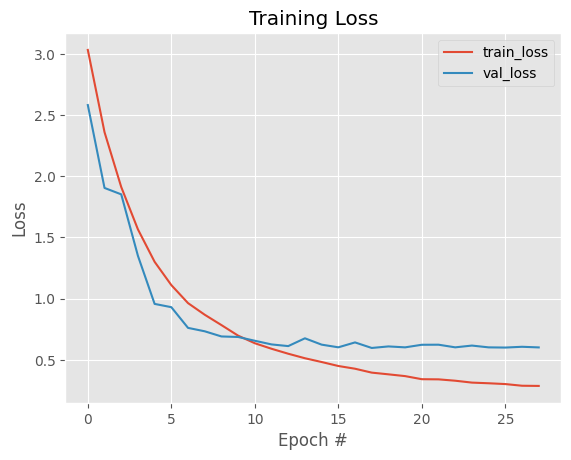

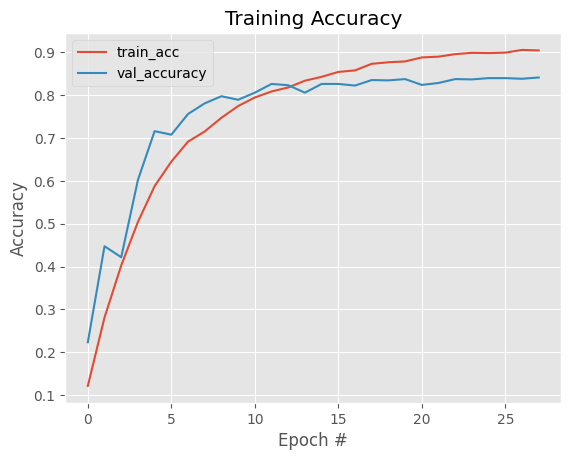

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.98      0.92      0.95        62
        down       0.87      0.76      0.81        62
       eight       0.92      0.89      0.90        62
        five       0.85      0.90      0.88        62
      follow       0.67      0.82      0.74        62
     forward       0.88      0.73      0.80        62
        four       0.80      0.73      0.76        62
          go       0.76      0.87      0.81        62
       learn       0.84      0.77      0.81        62
        left       0.90      0.90      0.90        62
        nine       0.89      0.92      0.90        62
          no       0.86      0.95      0.90        62
         off       0.88      0.82      0.85        62
          on       0.82      0.85      0.83        62
         one       0.88      0.90      0.89        62
       right       0.93      0.89      0.91        62
       seven       0.91      0.94      0.92       

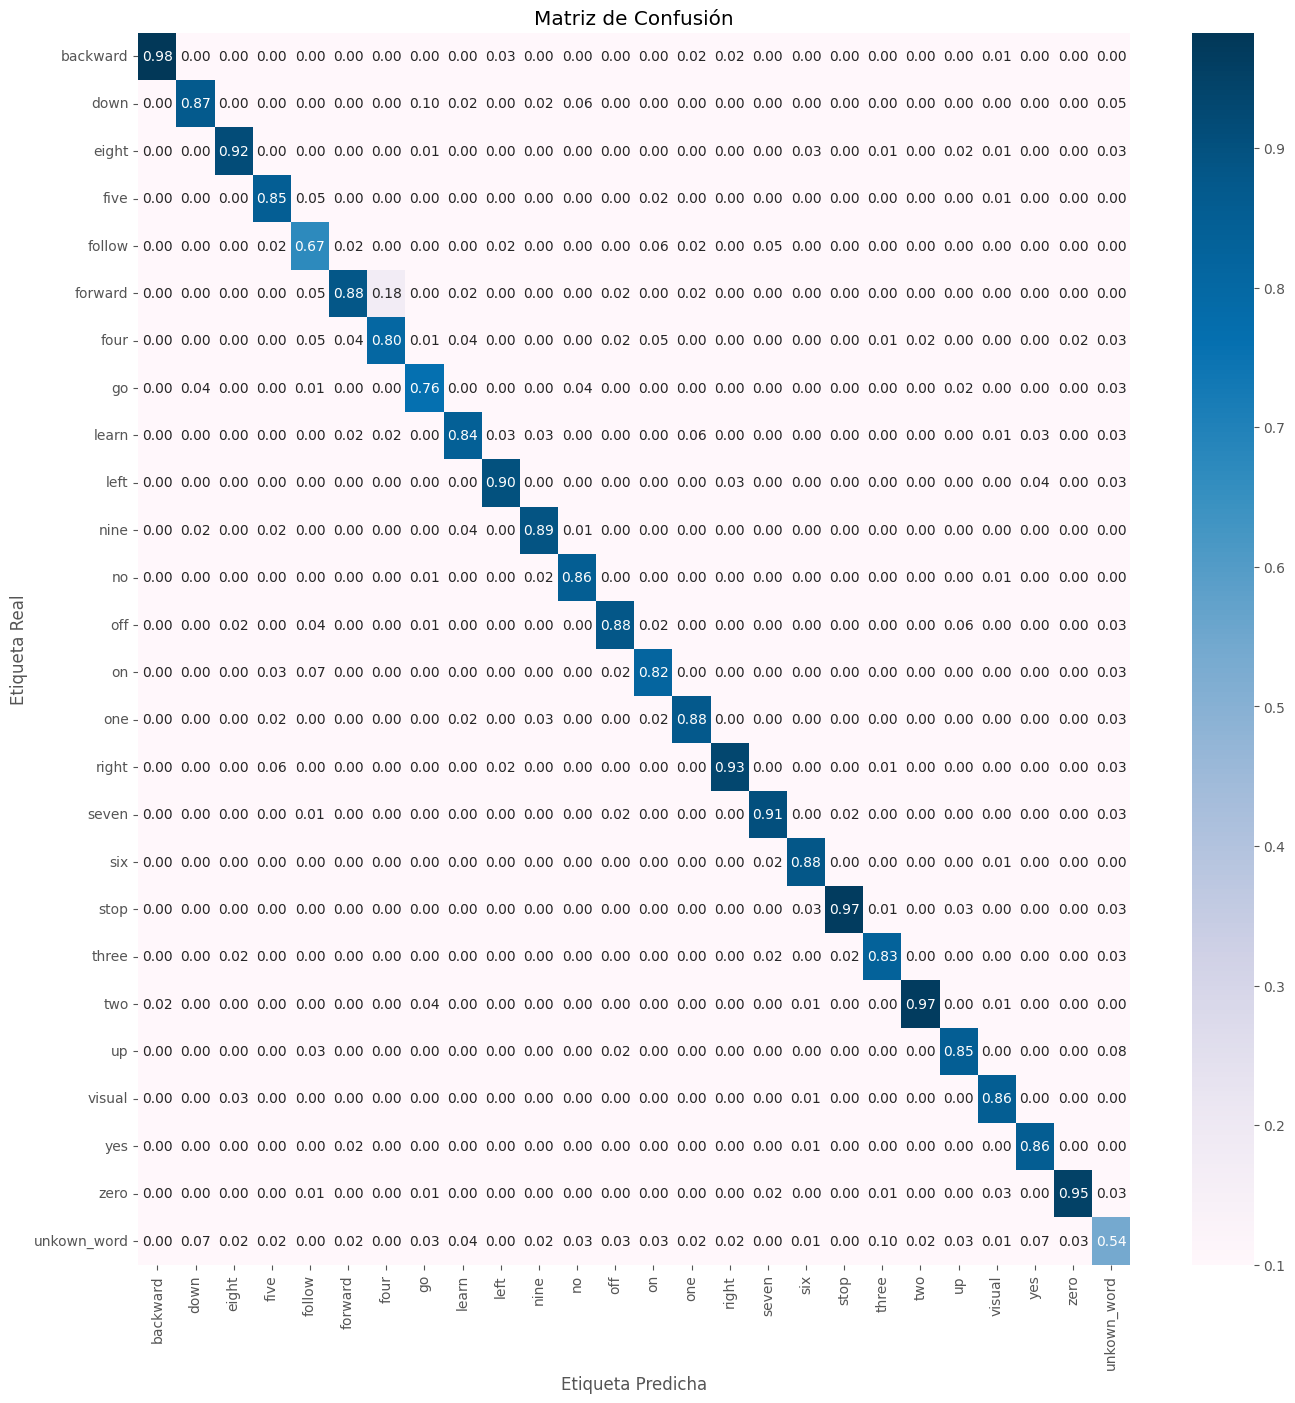

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_1_07, h_exp_a_cnn_lme_1_07, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_1_08

In [ ]:
exp_a_cnn_lme_1_08 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),  # Aplanar para pasar a capas densas

    # Capa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_1_08.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_1_08.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_1_08.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_1_08 = exp_a_cnn_lme_1_08.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1392 - loss: 3.0451
Epoch 1: val_loss improved from inf to 2.03014, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.1394 - loss: 3.0439 - val_accuracy: 0.3955 - val_loss: 2.0301 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5096 - loss: 1.6135
Epoch 2: val_loss improved from 2.03014 to 1.11672, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5101 - loss: 1.6118 - val_accuracy: 0.6589 - val_loss: 1.1167 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6486 - loss: 1.1076
Epoch 3: val_loss improved from 1.11672 to 0.99827, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6488 - loss: 1.1070 - val_accuracy: 0.6951 - val_loss: 0.9983 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7306 - loss: 0.8453
Epoch 4: val_loss improved from 0.99827 to 0.82737, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7307 - loss: 0.8450 - val_accuracy: 0.7442 - val_loss: 0.8274 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7806 - loss: 0.6918
Epoch 5: val_loss improved from 0.82737 to 0.77056, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7806 - loss: 0.6918 - val_accuracy: 0.7517 - val_loss: 0.7706 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8223 - loss: 0.5546
Epoch 6: val_loss improved from 0.77056 to 0.70507, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8223 - loss: 0.5545 - val_accuracy: 0.7796 - val_loss: 0.7051 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8440 - loss: 0.4943
Epoch 7: val_loss improved from 0.70507 to 0.68513, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8440 - loss: 0.4941 - val_accuracy: 0.7947 - val_loss: 0.6851 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8632 - loss: 0.4120
Epoch 8: val_loss did not improve from 0.68513
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8632 - loss: 0.4119 - val_accuracy: 0.7887 - val_loss: 0.6876 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8770 - loss: 0.3647
Epoch 9: val_loss did not improve from 0.68513
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8770 - loss: 0.3646 - val_accuracy: 0.7985 - val_loss: 0.6894 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8998 - loss: 0.3083 - val_accuracy: 0.8151 - val_loss: 0.6750 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9119 - loss: 0.2678
Epoch 11: val_loss did not improve from 0.67495
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9119 - loss: 0.2678 - val_accuracy: 0.7977 - val_loss: 0.7359 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9267 - loss: 0.2303
Epoch 12: val_loss did not improve from 0.67495
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9268 - loss: 0.2301 - val_accuracy: 0.8060 - val_loss: 0.7104 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

In [ ]:
exp_a_cnn_lme_1_08.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 61, 126, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 61, 126, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 28, 61, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 28, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 12, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 12, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 6, 14, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 6, 14, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │         344,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,344,816 (5.13 MB)

 Trainable params: 448,122 (1.71 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 896,246 (3.42 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


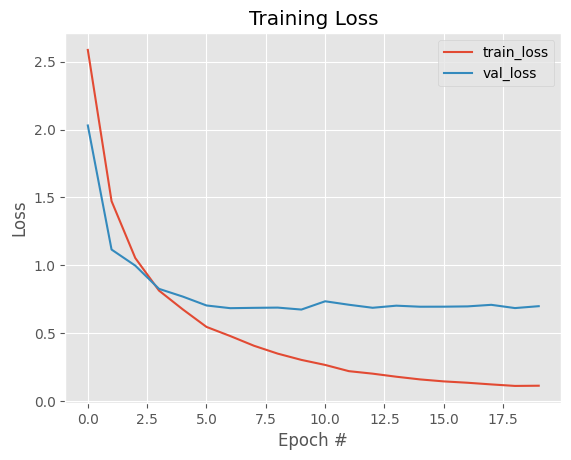

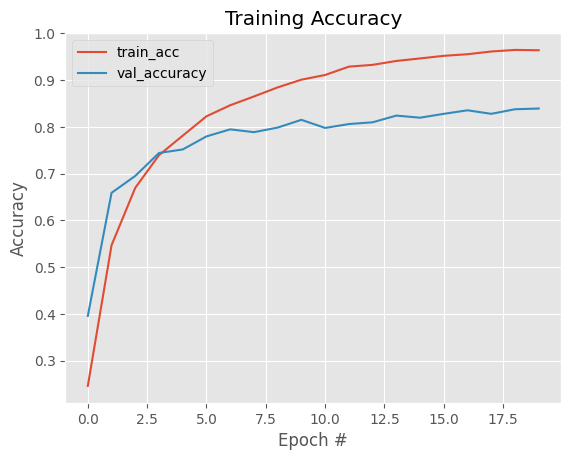

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.87      0.98      0.92        62
        down       0.84      0.77      0.81        62
       eight       0.85      0.90      0.88        62
        five       0.83      0.87      0.85        62
      follow       0.68      0.77      0.72        62
     forward       0.82      0.81      0.81        62
        four       0.79      0.81      0.80        62
          go       0.77      0.92      0.84        62
       learn       0.81      0.69      0.75        62
        left       0.91      0.85      0.88        62
        nine       0.81      0.90      0.85        62
          no       0.78      0.94      0.85        62
         off       0.91      0.79      0.84        62
          on       0.72      0.81      0.76        62
         one       0.84      0.84      0.84        62
       right       0.96      0.85      0.91        62
       seven       0.90      0.85      0.88       

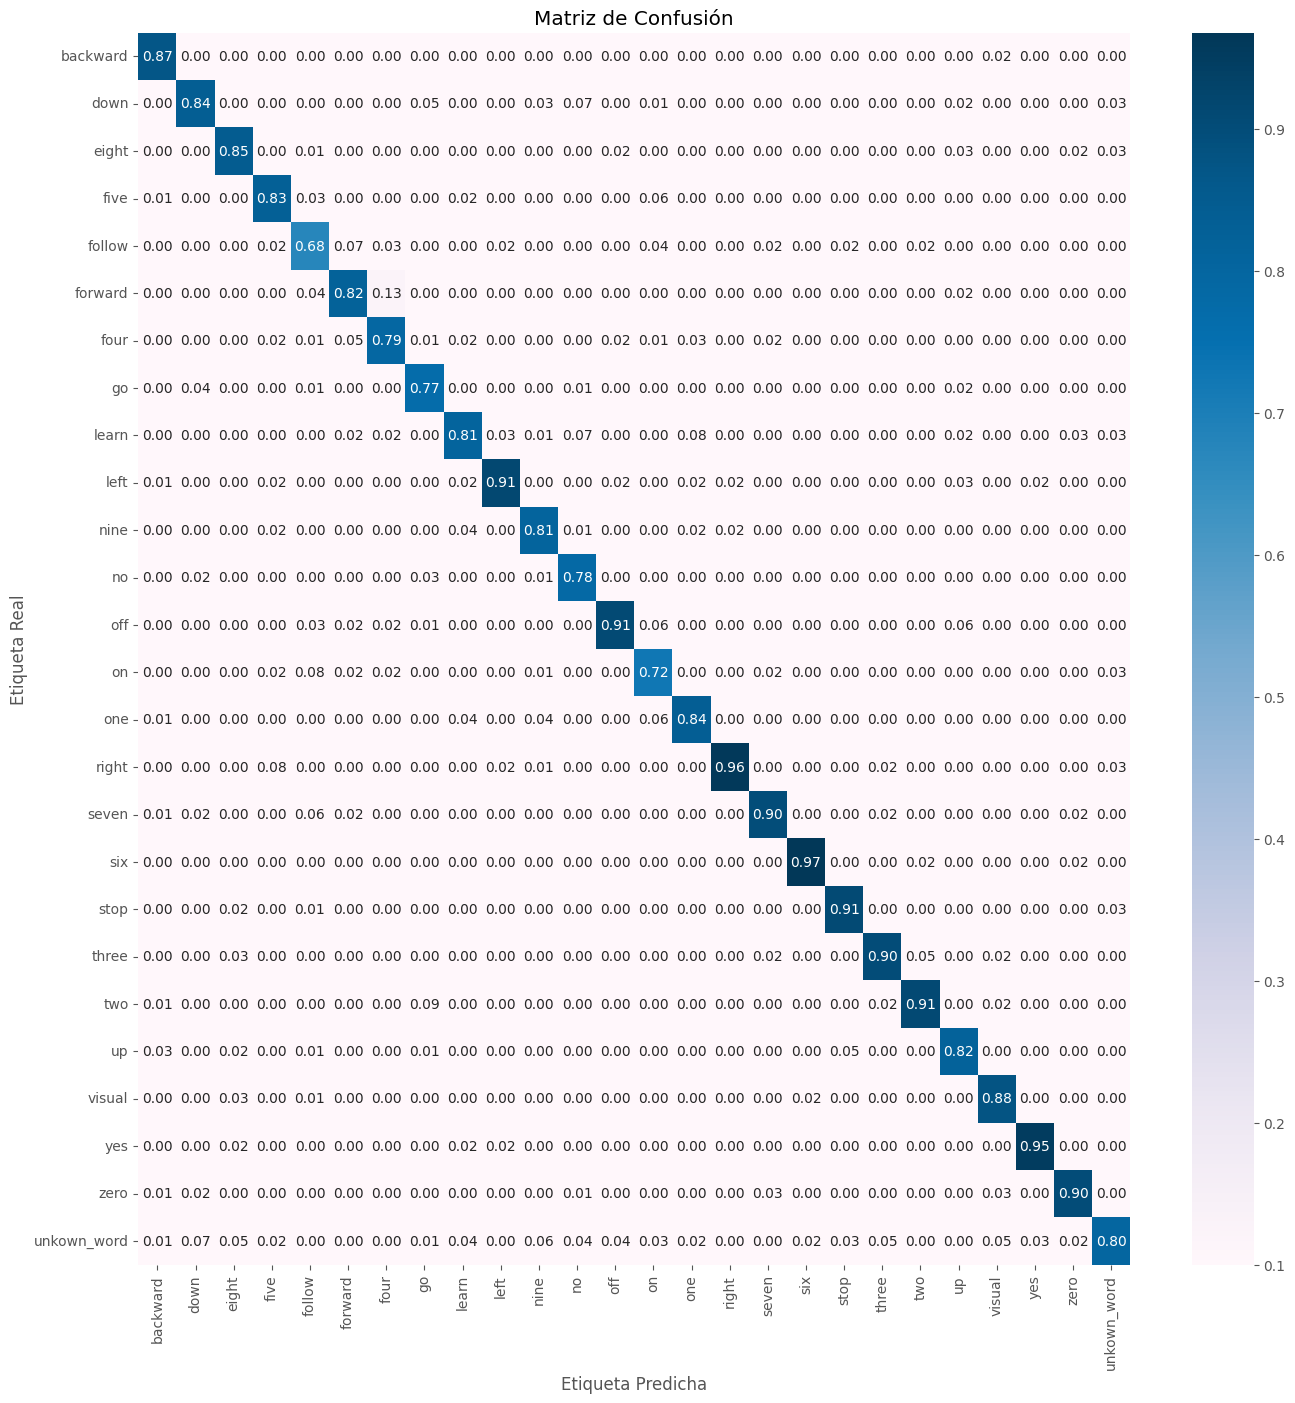

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_1_08, h_exp_a_cnn_lme_1_08, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_1_09

In [ ]:
exp_a_cnn_lme_1_09 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),  # Aplanar para pasar a capas densas

    # Capa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.1),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_1_09.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_1_09.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_1_09.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_1_09 = exp_a_cnn_lme_1_09.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2237 - loss: 2.8175
Epoch 1: val_loss improved from inf to 2.04184, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.2239 - loss: 2.8161 - val_accuracy: 0.3743 - val_loss: 2.0418 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5896 - loss: 1.3430
Epoch 2: val_loss improved from 2.04184 to 1.46189, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5899 - loss: 1.3420 - val_accuracy: 0.5592 - val_loss: 1.4619 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7168 - loss: 0.9076
Epoch 3: val_loss improved from 1.46189 to 1.14003, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7169 - loss: 0.9075 - val_accuracy: 0.6626 - val_loss: 1.1400 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7920 - loss: 0.6508
Epoch 4: val_loss improved from 1.14003 to 0.98153, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7922 - loss: 0.6501 - val_accuracy: 0.7268 - val_loss: 0.9815 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8392 - loss: 0.4990
Epoch 5: val_loss improved from 0.98153 to 0.82063, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8393 - loss: 0.4986 - val_accuracy: 0.7608 - val_loss: 0.8206 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8789 - loss: 0.3823
Epoch 6: val_loss did not improve from 0.82063
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8790 - loss: 0.3818 - val_accuracy: 0.7608 - val_loss: 0.8718 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9062 - loss: 0.3034
Epoch 7: val_loss improved from 0.82063 to 0.70752, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9062 - loss: 0.3033 - val_accuracy: 0.8015 - val_loss: 0.7075 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9239 - loss: 0.2397
Epoch 8: val_loss did not improve from 0.70752
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9240 - loss: 0.2395 - val_accuracy: 0.7668 - val_loss: 0.8580 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9389 - loss: 0.1985
Epoch 9: val_loss did not improve from 0.70752
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9389 - loss: 0.1984 - val_accuracy: 0.8091 - val_loss: 0.7374 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9681 - loss: 0.1093 - val_accuracy: 0.8355 - val_loss: 0.7052 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9742 - loss: 0.0871
Epoch 13: val_loss did not improve from 0.70523
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9742 - loss: 0.0870 - val_accuracy: 0.8294 - val_loss: 0.7056 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9764 - loss: 0.0782
Epoch 14: val_loss improved from 0.70523 to 0.69151, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_1_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9764 - loss: 0.0782 - val_accuracy: 0.8309 - val_loss: 0.6915 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9762 - loss: 0.0741
Epoch 15: val_loss did not improve from 0.69151
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9763 - loss: 0.0739 - val_accuracy: 0.8294 - val_loss: 0.7087 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9840 - loss: 0.0584
Epoch 16: val_loss did not improve from 0.69151
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9840 - loss: 0.0584 - val_accuracy: 0.8264 - val_loss: 0.7076 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

In [ ]:
exp_a_cnn_lme_1_09.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 61, 126, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 61, 126, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 30, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 28, 61, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 28, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 12, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 12, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 6, 14, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 6, 14, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │         344,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,325,040 (5.05 MB)

 Trainable params: 441,530 (1.68 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 883,062 (3.37 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


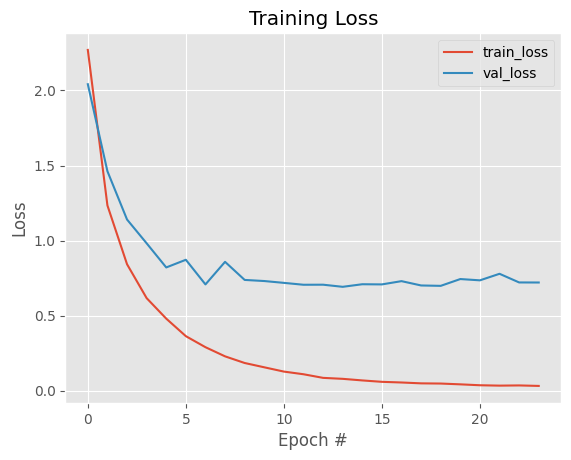

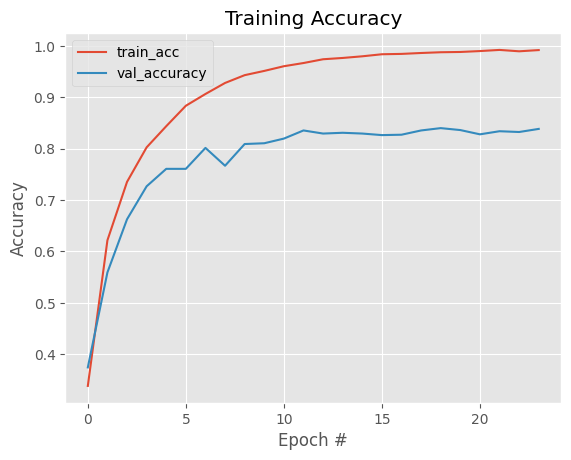

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.82      0.98      0.90        62
        down       0.84      0.79      0.82        62
       eight       0.89      0.90      0.90        62
        five       0.89      0.89      0.89        62
      follow       0.79      0.84      0.81        62
     forward       0.81      0.81      0.81        62
        four       0.81      0.71      0.76        62
          go       0.78      0.79      0.78        62
       learn       0.78      0.79      0.78        62
        left       0.95      0.90      0.93        62
        nine       0.85      0.92      0.88        62
          no       0.79      0.97      0.87        62
         off       0.95      0.85      0.90        62
          on       0.84      0.87      0.86        62
         one       0.86      0.89      0.87        62
       right       1.00      0.85      0.92        62
       seven       0.94      0.82      0.88       

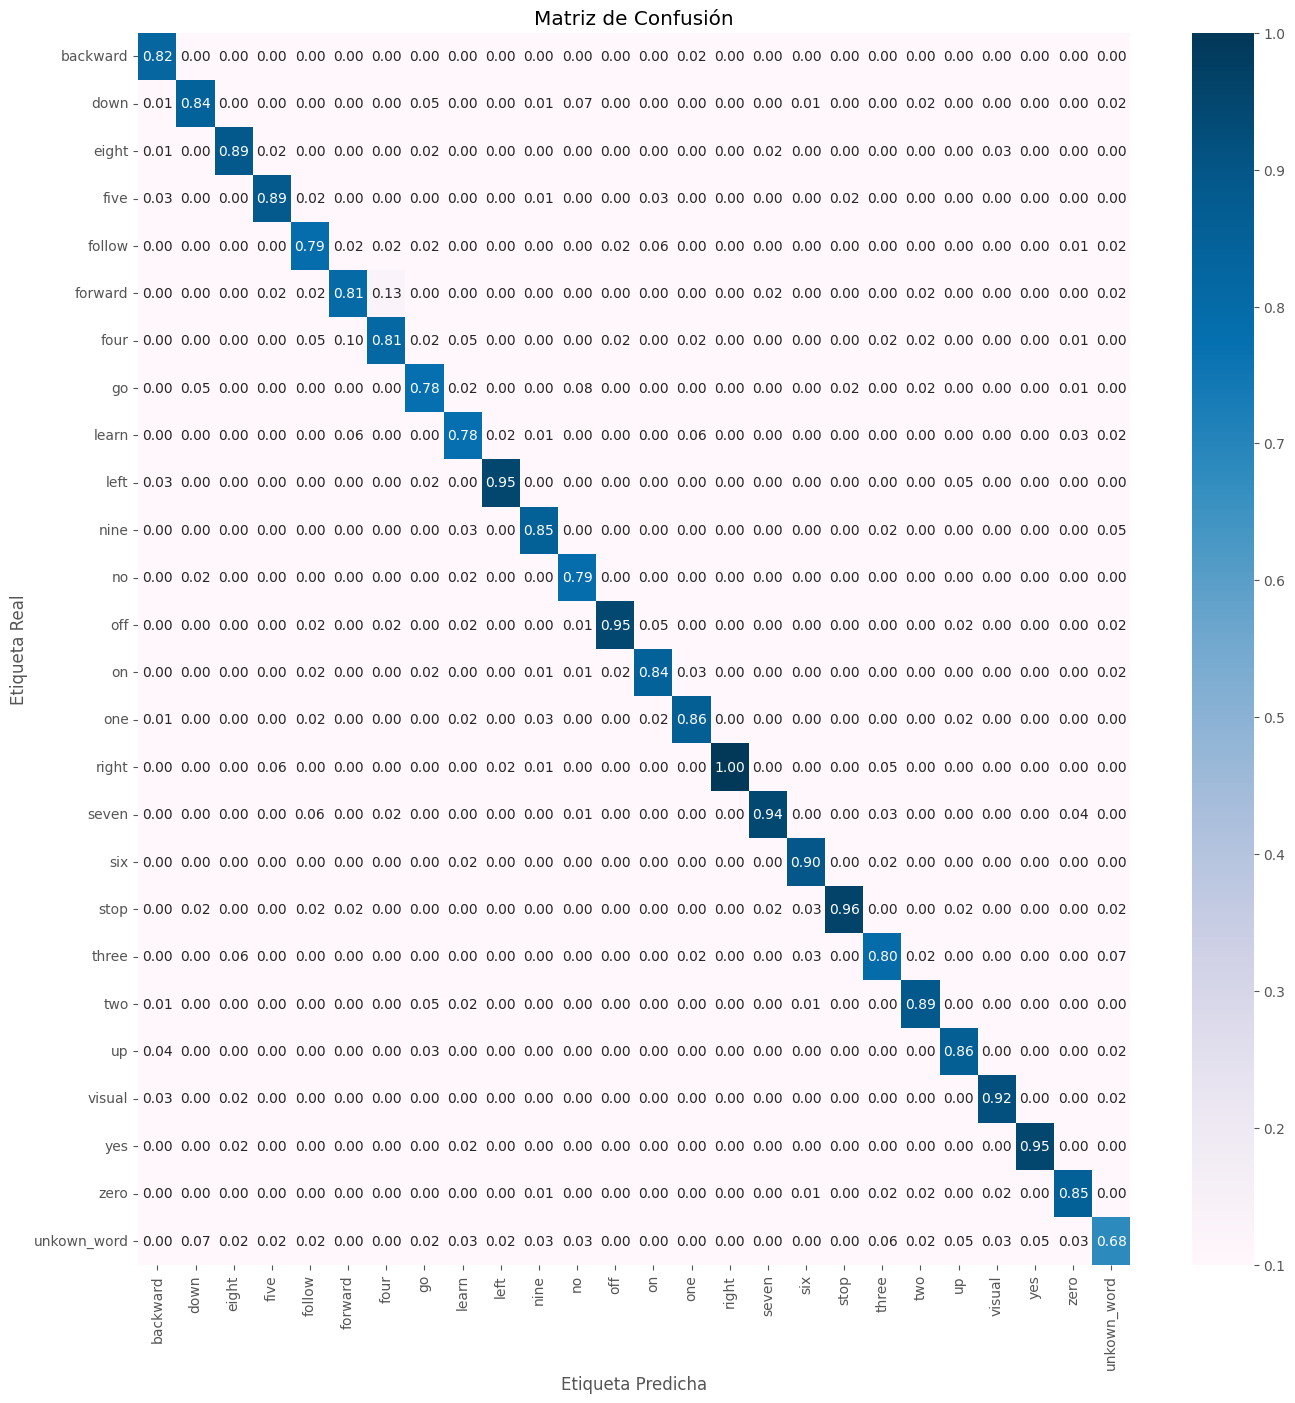

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_1_09, h_exp_a_cnn_lme_1_09, x_test, y_test, batch_size, classes)
mis.show_all()